In [ ]:
import os
import sys
import json
import time
import random

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sn

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

import cv2

import IPython.display as ipd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import  ToTensor, Normalize

import librosa
import IPython.display as ipd
import librosa.display

# Common operations:

In [ ]:
drive = True

if drive:
    from google.colab import drive
    drive.mount('/content/drive')

    import sys
    #sys.path.insert(0, '/content/drive/MyDrive/Uni/NNDL/project')
    sys.path.insert(0, '/content/drive/MyDrive/project')


    import utils

    #DATA_DIR = '/content/drive/MyDrive/Uni/NNDL/project'
    DATA_DIR = '/content/drive/MyDrive/project'

else:

    import utils

    DATA_DIR = '.'

Mounted at /content/drive


In [ ]:
def set_seed(seed, use_gpu = False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        print("CUDA is available")
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 12345678
USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())

CUDA is available


## Use metadata to get track_id and genre

In [ ]:
metadata_df = pd.read_csv(os.path.join(DATA_DIR, "total_metadata.csv"))
print(metadata_df.shape)

metadata_df.head()

(7994, 3)


track_id genre_top  top_genre_ind
0         2   Hip-Hop              0
1         5   Hip-Hop              0
2        10       Pop              1
3       140      Folk              2
4       141      Folk              2

In [ ]:
# shuffle the dataframe
metadata_df = metadata_df.sample(frac=1)
metadata_df.reset_index(drop=True, inplace=True)

metadata_df.head()

track_id      genre_top  top_genre_ind
0    122077           Rock              4
1     41568            Pop              1
2    114392     Electronic              6
3     47662           Folk              2
4     56692  International              5

In [ ]:
# split the dataframe in 80% -> train, 10% -> valid, 10% -> test

total_rows = len(metadata_df)
split_1_size = int(0.8 * total_rows)
split_2_size = int(0.1 * total_rows)

# Split the DataFrame into three parts
train_df = metadata_df.iloc[:split_1_size]
valid_metadata_df = metadata_df.iloc[split_1_size:split_1_size + split_2_size]
test_metadata_df = metadata_df.iloc[split_1_size + split_2_size:]

# Reset the index
train_df.reset_index(drop=True, inplace=True)
valid_metadata_df.reset_index(drop=True, inplace=True)
test_metadata_df.reset_index(drop=True, inplace=True)

In [ ]:
print(valid_metadata_df.shape)

valid_metadata_df.head()

(799, 3)


track_id     genre_top  top_genre_ind
0      4685       Hip-Hop              0
1     37113  Instrumental              7
2     47077    Electronic              6
3     32081          Rock              4
4    124183  Instrumental              7

In [ ]:
print(test_metadata_df.shape)

test_metadata_df.head()

(800, 3)


track_id      genre_top  top_genre_ind
0     54149   Instrumental              7
1      4013           Folk              2
2    106876           Rock              4
3     69727           Rock              4
4    148076  International              5

In [ ]:
print("train:", len(train_df))

train_df.head()

train: 6395


track_id      genre_top  top_genre_ind
0    122077           Rock              4
1     41568            Pop              1
2    114392     Electronic              6
3     47662           Folk              2
4     56692  International              5

In [ ]:
class_names = ['Hip-Hop',
 'Pop',
 'Folk',
 'Rock',
 'Experimental',
 'International',
 'Electronic',
 'Instrumental']

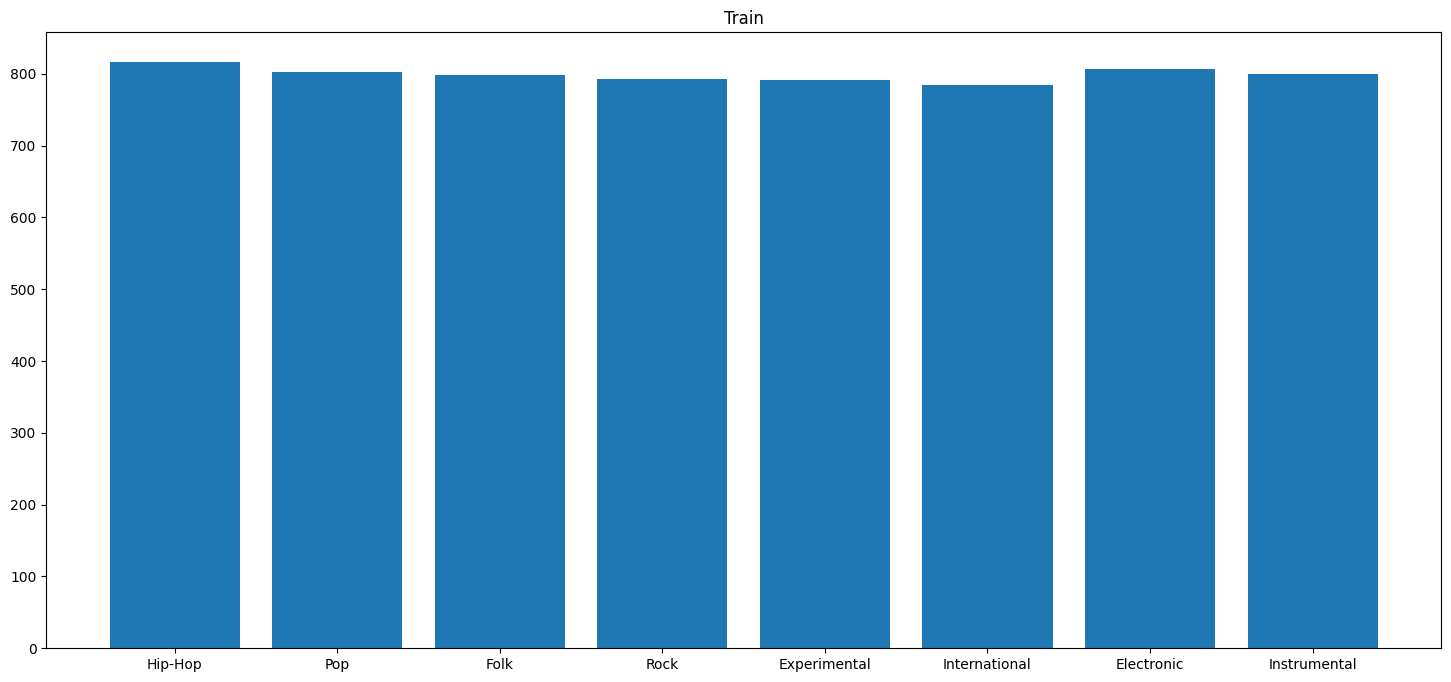

In [ ]:
# plot of the distribution

fig, ax = plt.subplots(figsize=(18,8))

ax.bar(class_names, np.histogram(train_df.top_genre_ind, len(class_names))[0])
ax.set_title('Train')
plt.show()

## Define useful functions:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    # release all unoccupied cached memory
    torch.cuda.empty_cache()
    # printo GPU info
    device_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print("{} {} GPU available".format(str(device_count), str(device_name)))

1 Tesla T4 GPU available


In [ ]:
device

device(type='cuda')

### Get size of an stft

In [ ]:
def get_size(file):


    format_spec = "{:<26} {:<18} {:<16} {:<14}"



    if torch.is_tensor(file):
        file_size = sys.getsizeof(file.storage())/10**6
    else: file_size = file.nbytes/10**6


    print(format_spec.format("object type:", "shape:", "data type:", "size [Mb]:"), "\n")
    print(format_spec.format(str(type(file)), str(list(file.shape)), str(file.dtype), str(round(file_size, 3))))



### Define function for training phase

In [ ]:
def compute_CM_elements(y_logits, y):

    """
    Input
    ----------------------------------------------------
    y_logits: [BATCH_SIZE, N_CLASSES]
    y:        [BATCH_SIZE] (dense encoding)
    ----------------------------------------------------

    Temporary
    ------------------------------------------------------------------------
    y_prob:      [BATCH_SIZE, N_CLASSES]
    y_pred:      [BATCH_SIZE]
    y_pred_bool: [BATCH_SIZE, N_CLASSES] (one-hot encoding)
    y_bool:      [BATCH_SIZE, N_CLASSES] (one-hot encoding)
    ------------------------------------------------------------------------

    Output
    ---------------
    TP: [N_CLASSES]
    FP: [N_CLASSES]
    TN: [N_CLASSES]
    FN: [N_CLASSES]
    ---------------
    """

    y_prob = F.softmax(y_logits, dim = 1)
    y_pred = y_prob.argmax(dim = 1)

    y_pred_bool = F.one_hot(y_pred, num_classes = 8).bool()
    y_bool = F.one_hot(y, num_classes = 8).bool()

    TP = torch.sum(torch.logical_and(y_pred_bool, y_bool), dim = 0)
    FP = torch.sum(y_pred_bool, dim = 0) - TP
    TN = torch.sum(torch.logical_and(~y_pred_bool, ~y_bool), dim = 0)
    FN = torch.sum(~y_pred_bool, dim = 0) - TN

    return TP, FP, TN, FN

In [ ]:
def compute_metrics(loss, TP, FP, TN, FN):

    # loss
    loss = loss

    # IoU and macro-averaging IoU
    IoU = TP/(TP + FP + FN)
    MA_IoU = torch.sum(IoU)/8

    # accuracy and macro-averaging accuracy
    accuracy = (TP + TN)/(TP + FP + TN + FN)
    MA_accuracy = torch.sum(accuracy)/8

    # precision and macro-averaging precision
    precision = TP/(TP + FP)
    MA_precision = torch.sum(precision)/8

    # recall and macro-averaging recall
    recall = TP/(TP + FN)
    MA_recall = torch.sum(recall)/8

    # F1-score and macro-averaging F1-score
    F1_score = 2*(precision*recall)/(precision + recall)
    MA_F1_score = 2*(MA_precision*MA_recall)/(MA_precision + MA_recall)

    metrics = {
        "loss": loss.item(),
        "IoU": IoU.tolist(),
        "MA_IoU": MA_IoU.item(),
        "accuracy": accuracy.tolist(),
        "MA_accuracy": MA_accuracy.item(),
        "precision": precision.tolist(),
        "MA_precision": MA_precision.item(),
        "recall": recall.tolist(),
        "MA_recall": MA_recall.item(),
        "F1_score": F1_score.tolist(),
        "MA_F1_score": MA_F1_score.item()
    }

    return metrics

In [ ]:
def train(model, iterator, criterion, optimizer, device, desc = "Train"):

    epoch_loss = 0

    epoch_TP = 0
    epoch_FP = 0
    epoch_TN = 0
    epoch_FN = 0

    # set train mode
    model.train()

    # loop over batches
    for x, y in tqdm(iterator, desc = desc):

        if type(x) is list:
            # move data to the GPU
            x[0] = x[0].to(device)
            x[1] = x[1].to(device)
        else:
            # move data to the GPU
            x = x.to(device)

        # set gradients to zero
        optimizer.zero_grad()

        # make predictions
        y_logits = model(x)

        # move data to the GPU
        y = y.to(device)

        # compute loss
        loss = criterion(y_logits, y.long())

        # compute confusion matrix elements
        TP, FP, TN, FN = compute_CM_elements(y_logits, y.long())

        # compute gradients
        loss.backward()

        # update the weights according to the optimizer using the gradients
        optimizer.step()

        # update loss
        epoch_loss += loss/len(iterator)

        # update confusion matrix elements
        epoch_TP += TP
        epoch_FP += FP
        epoch_TN += TN
        epoch_FN += FN

    epoch_metrics = compute_metrics(epoch_loss, epoch_TP, epoch_FP, epoch_TN, epoch_FN)

    return epoch_metrics

In [ ]:
def evaluate(model, iterator, criterion, device, desc = "Valid"):

    epoch_loss = 0

    epoch_TP = 0
    epoch_FP = 0
    epoch_TN = 0
    epoch_FN = 0

    # set evaluation mode
    model.eval()

    # disable gradient tracking
    with torch.no_grad():

        # loop over batches
        for x, y in tqdm(iterator, desc = desc):

            if type(x) is list:
                # move data to the GPU
                x[0] = x[0].to(device)
                x[1] = x[1].to(device)
            else:
                # move data to the GPU
                x = x.to(device)


            # make predictions
            y_logits = model(x)

            # move data to the GPU
            y = y.to(device)

            # compute loss
            loss = criterion(y_logits, y.long())

            # compute confusion matrix elements
            TP, FP, TN, FN = compute_CM_elements(y_logits, y.long())

            # update loss
            epoch_loss += loss/len(iterator)

            # update confusion matrix elements
            epoch_TP += TP
            epoch_FP += FP
            epoch_TN += TN
            epoch_FN += FN

    epoch_metrics = compute_metrics(epoch_loss, epoch_TP, epoch_FP, epoch_TN, epoch_FN)

    return epoch_metrics

In [ ]:
def model_training(n_epochs, model, train_iterator, valid_iterator, criterion, optimizer, scheduler, device,
                   checkpoint_name = "checkpoint.pt", results_name = "results.csv"):

    # initialize validation loss
    best_valid_loss = float('inf')

    train_metrics_log = {}
    valid_metrics_log = {}

    print("----------------------------------------------------------")

    # loop over epochs
    for epoch in range(n_epochs):

        print(f"\nEpoch: {epoch + 1}/{n_epochs}\n")

        start_time = time.time()

        # training
        train_metrics = train(model, train_iterator, criterion, optimizer, device, desc = "Train")

        # validation
        valid_metrics = evaluate(model, valid_iterator, criterion, device,desc = "Valid")

        print(f"\nTrain:", \
              f"Loss = {train_metrics['loss']:.4f},", \
              f"MA_IoU = {train_metrics['MA_IoU']*100:.2f} %,", \
              f"MA_acc = {train_metrics['MA_accuracy']*100:.2f} %,", \
              f"MA_prec = {train_metrics['MA_precision']*100:.2f} %,", \
              f"MA_rec = {train_metrics['MA_recall']*100:.2f} %,", \
              f"MA_F1_score = {train_metrics['MA_F1_score']*100:.2f} %")

        print(f"Valid:", \
              f"Loss = {valid_metrics['loss']:.4f},", \
              f"MA_IoU = {valid_metrics['MA_IoU']*100:.2f} %,", \
              f"MA_acc = {valid_metrics['MA_accuracy']*100:.2f} %,", \
              f"MA_prec = {valid_metrics['MA_precision']*100:.2f} %,", \
              f"MA_rec = {valid_metrics['MA_recall']*100:.2f} %,", \
              f"MA_F1_score = {valid_metrics['MA_F1_score']*100:.2f} %")

        # scheduler
        if scheduler:
            scheduler.step()

        end_time = time.time()

        print(f"\nEpoch Time: {end_time-start_time:.2f} s\n")
        print("----------------------------------------------------------")

        # model checkpoint
        if valid_metrics["loss"] < best_valid_loss:
            best_valid_loss = valid_metrics["loss"]
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "criterion_state_dict": criterion.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict() if bool(scheduler) else None,
            }, os.path.join(DATA_DIR + '/checkpoints', checkpoint_name))

        # save train metrics
        for key in train_metrics.keys():
            if key not in train_metrics_log:
                train_metrics_log[key] = []
            train_metrics_log[key].append(train_metrics[key])

        pd.DataFrame.from_dict(train_metrics_log).to_csv(DATA_DIR+"/results/train_" + results_name, index = False)

        # save valid metrics
        for key in valid_metrics.keys():
            if key not in valid_metrics_log:
                valid_metrics_log[key] = []
            valid_metrics_log[key].append(valid_metrics[key])

        pd.DataFrame.from_dict(valid_metrics_log).to_csv(DATA_DIR + "/results/valid_" + results_name, index = False)

    return train_metrics_log, valid_metrics_log

### Define functions to plot results

In [ ]:
colors = ['k', 'orange', 'brown', 'red', 'blue', 'green', 'pink', 'yellow']

In [ ]:
def plot_results(checkpoint_name = "checkpoint.pt", results_name = "results.csv"):

    # load results into dataframes constrained by checkpoint epoch
    if not isinstance(checkpoint_name, list):
        best_epoch = torch.load(os.path.join(DATA_DIR + '/checkpoints', checkpoint_name, map_location=device))["epoch"]
        train_results_df = pd.read_csv(DATA_DIR + "/results/train_" + results_name).iloc[:best_epoch]
        valid_results_df = pd.read_csv(DATA_DIR + "/results/valid_" + results_name).iloc[:best_epoch]
    else:
        train_frames = []
        valid_frames = []
        for i in range(len(checkpoint_name)):
            best_epoch = torch.load(os.path.join(DATA_DIR + '/checkpoints', checkpoint_name[i]), map_location=device)["epoch"]
            train_frames.append(pd.read_csv(DATA_DIR + "/results/train_" + results_name[i]).iloc[:best_epoch])
            valid_frames.append(pd.read_csv(DATA_DIR + "/results/valid_" + results_name[i]).iloc[:best_epoch])
        train_results_df = pd.concat(train_frames, ignore_index = True)
        valid_results_df = pd.concat(valid_frames, ignore_index = True)

    assert len(train_results_df) == len(valid_results_df)
    n_epochs = len(train_results_df)

    plt.figure(figsize = (21, 14))

    n_rows = 3
    n_cols = 3
    idx = 1

    y_ranges = [(1, 1.9), (0.1, 0.6), (0.1, 0.7)]

    for i, metric in enumerate(["loss", "MA_IoU", "MA_F1_score", "MA_precision", "MA_recall", "MA_accuracy"]):

        plt.subplot(n_rows, n_cols, idx)
        idx += 1
        plt.plot(np.arange(n_epochs) + 1, train_results_df[metric], linewidth = 3, color = "tab:blue", label = "Train")
        plt.plot(np.arange(n_epochs) + 1, valid_results_df[metric], linewidth = 3, color = "tab:orange", label = "Valid")
        if i < 3:
            plt.ylim(bottom = y_ranges[i][0], top = y_ranges[i][1])
        plt.xlabel("epoch", fontsize = 14), plt.ylabel(metric, fontsize = 14)
        plt.xticks(fontsize = 12), plt.yticks(fontsize = 12)
        plt.legend(fontsize = 12)
        plt.grid()

    #plt.savefig("./images/results_MGC.png", dpi = 300)
    plt.show()

In [ ]:
def plot_results_per_class(class_names, colors, checkpoint_name = "checkpoint.pt", results_name = "results.csv"):

    # load results into dataframes constrained by checkpoint epoch
    if not isinstance(checkpoint_name, list):
        best_epoch = torch.load(os.path.join(DATA_DIR + '/checkpoints', checkpoint_name), map_location=device)["epoch"]
        train_results_df = pd.read_csv(DATA_DIR + "/results/train_" + results_name).iloc[:best_epoch]
        valid_results_df = pd.read_csv(DATA_DIR + "/results/valid_" + results_name).iloc[:best_epoch]
    else:
        train_frames = []
        valid_frames = []
        for i in range(len(checkpoint_name)):
            best_epoch = torch.load(os.path.join(DATA_DIR + '/checkpoints', checkpoint_name[i]), map_location=device)["epoch"]
            train_frames.append(pd.read_csv(DATA_DIR +"/results/train_" + results_name[i]).iloc[:best_epoch])
            valid_frames.append(pd.read_csv(DATA_DIR +"/results/valid_" + results_name[i]).iloc[:best_epoch])
        train_results_df = pd.concat(train_frames, ignore_index = True)
        valid_results_df = pd.concat(valid_frames, ignore_index = True)

    assert len(train_results_df) == len(valid_results_df)
    n_epochs = len(train_results_df)

    plt.figure(figsize = (18, 30))
    n_rows = 5
    n_cols = 2
    idx = 1

    for metric in ["IoU", "accuracy", "precision", "recall", "F1_score"]:

        train_metric = np.zeros((n_epochs, 8))
        valid_metric = np.zeros((n_epochs, 8))

        for i in range(n_epochs):
            train_metric[i] = np.array(json.loads(train_results_df[metric].iloc[i].replace("nan", "NaN")))
            valid_metric[i] = np.array(json.loads(valid_results_df[metric].iloc[i].replace("nan", "NaN")))

        # train
        plt.subplot(n_rows, n_cols, idx)
        idx += 1
        for j in range(8):
            plt.plot(np.arange(n_epochs) + 1, train_metric[:,j], linewidth = 3, color = colors[j], label = class_names[j],
                path_effects = ([pe.Stroke(linewidth = 5, foreground = "black"), pe.Normal()]))
        plt.xlabel("epoch", fontsize = 14)
        plt.ylabel(metric + " [Train]", fontsize = 14)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.subplots_adjust(right = 0.8)
        plt.grid()



        # valid
        plt.subplot(n_rows, n_cols, idx)
        idx += 1
        for j in range(8):
            plt.plot(np.arange(n_epochs) + 1, valid_metric[:,j], linewidth = 3, color =colors[j], label = class_names[j],
                path_effects = ([pe.Stroke(linewidth = 5, foreground = "black"), pe.Normal()]))
        plt.xlabel("Epoch", fontsize = 14)
        plt.ylabel(metric + " [Valid]", fontsize = 14)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.subplots_adjust(right = 0.8)
        plt.grid()

        plt.legend(bbox_to_anchor = (1.1, 0.5), loc = "center left", borderaxespad = 0, fontsize = 12)

    #plt.savefig("./results_per_class.png")
    plt.show()

### Define functions for testing phase

In [ ]:
def test(model, iterator, criterion, device, desc = "Test"):
    loss = 0
    CM = 0

    # set evaluation mode
    model.eval()

    # disable gradient tracking
    with torch.no_grad():

        # loop over batches
        for x, y in tqdm(iterator, desc = desc):

            if type(x) is list:
                # move data to the GPU
                x[0] = x[0].to(device)
                x[1] = x[1].to(device)
            else:
                # move data to the GPU
                x = x.to(device)

            # make predictions
            y_logits = model(x)

            # move data to the GPU
            y = y.to(device)

            # compute loss
            loss = criterion(y_logits, y.long())

            # get one hot prediction
            y_prob = F.softmax(y_logits, dim = 1)
            y_pred = y_prob.argmax(dim = 1)

            # update loss
            loss += loss/len(iterator)

            # update confusion matrix (CPU)
            CM += confusion_matrix(y.view(-1).tolist(), y_pred.view(-1).tolist(), labels = range(8))

    # move loss from GPU to CPU
    loss = loss.cpu()

    # compute TP, FP, TN, FN
    TP = CM.diagonal().copy()
    CM_no_diag = CM - np.diag(TP)
    FP = CM_no_diag.sum(axis = 0)
    FN = CM_no_diag.sum(axis = 1)
    TN = CM.sum() - (FP + FN + TP)

    # transfrom from numpy to tensor (CPU)
    TP = torch.from_numpy(TP)
    FP = torch.from_numpy(FP)
    TN = torch.from_numpy(TN)
    FN = torch.from_numpy(FN)

    metrics = compute_metrics(loss, TP, FP, TN, FN)

    return metrics, CM

In [ ]:
def model_testing(model, test_iterator, criterion, device,
                  checkpoint_name = "checkpoint.pt", results_name = "results.csv", CM_name = "confusion_matrix.csv"):

    # load checkpoint
    checkpoint = torch.load(os.path.join(DATA_DIR + '/checkpoints', checkpoint_name))
    model.load_state_dict(checkpoint["model_state_dict"])
    criterion.load_state_dict(checkpoint["criterion_state_dict"])

    metrics_log = {}

    # testing
    metrics, CM = test(model, test_iterator, criterion, device, desc = "Test")

    # save metrics
    for key in metrics.keys():
        if key not in metrics_log:
            metrics_log[key] = []
        metrics_log[key].append(metrics[key])

    pd.DataFrame.from_dict(metrics_log).to_csv(DATA_DIR + "/results/test_" + results_name, index = False)

    # save confusion matrix
    pd.DataFrame(CM).to_csv(DATA_DIR + "/results/" + CM_name, index = False)

In [ ]:
def plot_CM(class_names, CM_name = "confusion_matrix.csv"):

    CM = pd.read_csv(DATA_DIR + "/results/" + CM_name).values
    CM = normalize(CM, axis = 1, norm = "l1")

    fig, ax = plt.subplots(figsize = (9,7))
    ax = sn.heatmap(CM,
                    xticklabels = [s.split("_")[0] for s in class_names],
                    yticklabels = [s.split("_")[0] for s in class_names],
                    vmin = 0, vmax = 1,
                    cmap = "Blues",
                    fmt = ".2f",
                    ax = ax,
                    annot_kws = {"fontsize": 16},
                    #linewidths = 1, linecolor = "black",
                    annot = True)

    ax.collections[0].colorbar.ax.tick_params(labelsize = 16)
    plt.xticks(fontsize = 18, rotation = 90)
    plt.yticks(fontsize = 18, rotation = 0)
    plt.tight_layout()

    #plt.savefig("./images/CM_Densenet.png", dpi = 300, bbox_inches = "tight")
    plt.show()

### Define function for Resume Training

In [ ]:
def load_checkpoint(model, criterion, optimizer, scheduler, checkpoint_name = "checkpoint.pt"):

    checkpoint = torch.load(os.path.join(DATA_DIR+"/checkpoints", checkpoint_name, map_location=device))
    model.load_state_dict(checkpoint["model_state_dict"])
    criterion.load_state_dict(checkpoint["criterion_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if bool(checkpoint["scheduler_state_dict"]):
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    return model, criterion, optimizer, scheduler

### Define transformation to tensor

In [ ]:
post_transform = ToTensor()

### 1D normalization values

In [ ]:
NORM = False

def task_mean(id):

    filename = utils.get_audio_path(DATA_DIR + '/fma_small', id)
    x, sr = librosa.load(filename, sr=16000, mono=True)
    mean = np.mean(x)

    return mean

if NORM:
    train_means = process_map(task_mean, train_df["track_id"].tolist(), max_workers = os.cpu_count(), chunksize = 1)

In [ ]:
#train_mean = np.array(train_means).mean(axis = 0)
train_mean = np.array([-0.00052694825])
print(train_mean)

[-0.00052695]


In [ ]:
def task_var(id):

    filename = utils.get_audio_path(DATA_DIR + '/fma_small', id)
    x, sr = librosa.load(filename, sr=16000, mono=True) # sr = None -> default 22050
    var = np.var(x)

    return var

if NORM:
    train_vars = process_map(task_var, train_df["track_id"].tolist(), max_workers = os.cpu_count(), chunksize = 1)

In [ ]:
#train_var = np.array(train_vars).mean(axis = 0)
#train_std = np.sqrt(train_var)
train_std = np.array([0.21047254])
print(train_std)

[0.21047254]


#  Input 1D: Baseline A

## Create a custom dataset class

In [ ]:
class AudioDataset(Dataset):

    def __init__(self, df, mean_1D, std_1D, delta_t = 10, augmentation = True):

        # read track_id and the genre
        self.labels = df["top_genre_ind"].tolist()
        self.ids = df["track_id"].tolist()
        self.delta_t = int(delta_t)
        self.sr = 16000

        self.mean_1D = mean_1D
        self.std_1D = std_1D

        self.post_transform = post_transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):

        ind = self.ids[i]

        filename = utils.get_audio_path(DATA_DIR+'/fma_small', ind) # path and track_i

        # Time stretch
        stretch_factor = 1
        if np.random.uniform() < 0.5 and self.augmentation: stretch_factor = np.random.uniform(0.9,1.1)
        sr = self.sr*stretch_factor


        # Load track
        x, sr = librosa.load(filename, sr=sr, mono=True)
        start = np.random.randint(26-self.delta_t)
        end = start+self.delta_t
        x = x[start*self.sr:end*self.sr]


        # Add backgroundnoise
        if np.random.uniform() < 0.5 and self.augmentation:
          x_max = np.max(x)
          noise = np.random.normal(0, np.random.uniform(0, 0.03)*np.abs(x_max), len(x))
          x = x + noise

        # reshape
        x = torch.from_numpy(x.reshape(1,-1)) # ToTensor

        # Normalize 1D
        x = (x-self.mean_1D)/self.std_1D


        label = self.labels[i]


        # keep dense encoding -> nn.CrossEntropyLoss expects integer labels

        return x.float(), label

In [ ]:
# get size of an element from the train dataset
idx = 0
get_size(AudioDataset(train_df, train_mean, train_std, augmentation = True)[idx][0])

object type:               shape:             data type:       size [Mb]:     

<class 'torch.Tensor'>     [1, 160000]        torch.float32    0.64          


<ipython-input-14-949627a3073a>:9: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  file_size = sys.getsizeof(file.storage())/10**6


## Create train, valid and test datasets and their iterators

In [ ]:
train_dataset = AudioDataset(train_df, train_mean, train_std, 10, True)
valid_dataset = AudioDataset(valid_metadata_df, train_mean, train_std, 10, False)
test_dataset = AudioDataset(test_metadata_df, train_mean, train_std, 10, False)

In [ ]:
BATCH_SIZE = 16

# create iterators
train_iterator = DataLoader(train_dataset, shuffle = True, batch_size = BATCH_SIZE, drop_last = True)
valid_iterator = DataLoader(valid_dataset, batch_size = BATCH_SIZE, drop_last = True)
test_iterator = DataLoader(test_dataset, batch_size = BATCH_SIZE, drop_last = True)

# The drop_last=True parameter ignores the last batch (when the number of examples in your dataset is not divisible by your batch_size)

In [ ]:
# get size of an waveform from the train iterator (with transformations)
batch = next(iter(train_iterator))
get_size(batch[0])

object type:               shape:             data type:       size [Mb]:     

<class 'torch.Tensor'>     [16, 1, 160000]    torch.float32    10.24         


## Define the model

In [ ]:
class Baseline_A_1D(nn.Module):

    def __init__(self, genres_num = 8):
        super().__init__()

        ### Convolutional section
        self.baseline_cnn = nn.Sequential(

            # first convolutional block
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=256, stride=64, padding=128),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=4, stride=4, padding=0),


            # second convolutional block
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=32, stride=2, padding=16),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0),


            # third convolutional block
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=16, stride=2, padding=8),
            nn.BatchNorm1d(64),
            nn.ReLU(True),

        )


        self.first_right = nn.MaxPool1d(kernel_size=32, stride=6, padding=0)
        self.first_left = nn.AvgPool1d(kernel_size=32, stride=6, padding=0)

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.baseline_lin = nn.Sequential(

            # First linear layer
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(True),
            #nn.Dropout(0.2),

            # Second linear layer
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(True),
            #nn.Dropout(0.2),

            # Third linear layer
            nn.Linear(in_features=128, out_features=genres_num)
        )

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv1d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()


    def forward(self, x):
        x = self.baseline_cnn(x)
        print(x.shape)
        x_l = self.first_left(x)
        print(x_l.shape)
        x_r = self.first_right(x)
        print(x_r.shape)
        x = torch.cat([x_l, x_r], axis=1)
        print(x.shape)
        x = self.flatten(x)
        print(x.shape)
        x = self.baseline_lin(x)
        print(x.shape)
        return x

In [ ]:
model = Baseline_A_1D(8)
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 645080


## Training

In [ ]:
model = Baseline_A_1D(8)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-4)

scheduler = None

N_EPOCHS = 20

In [ ]:
TRAIN = False

RESUME = False

if TRAIN:
    if RESUME:
        # load checkpoint
        model, criterion, optimizer, scheduler = load_checkpoint(model,
                                                             criterion,
                                                             optimizer,
                                                             scheduler,
                                                             checkpoint_name = "checkpoint_Baseline_A_1D.pt")


    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          "checkpoint_Baseline_A_1D.pt",
                                                          "results_Baseline_A_1D.csv")

### Plot results

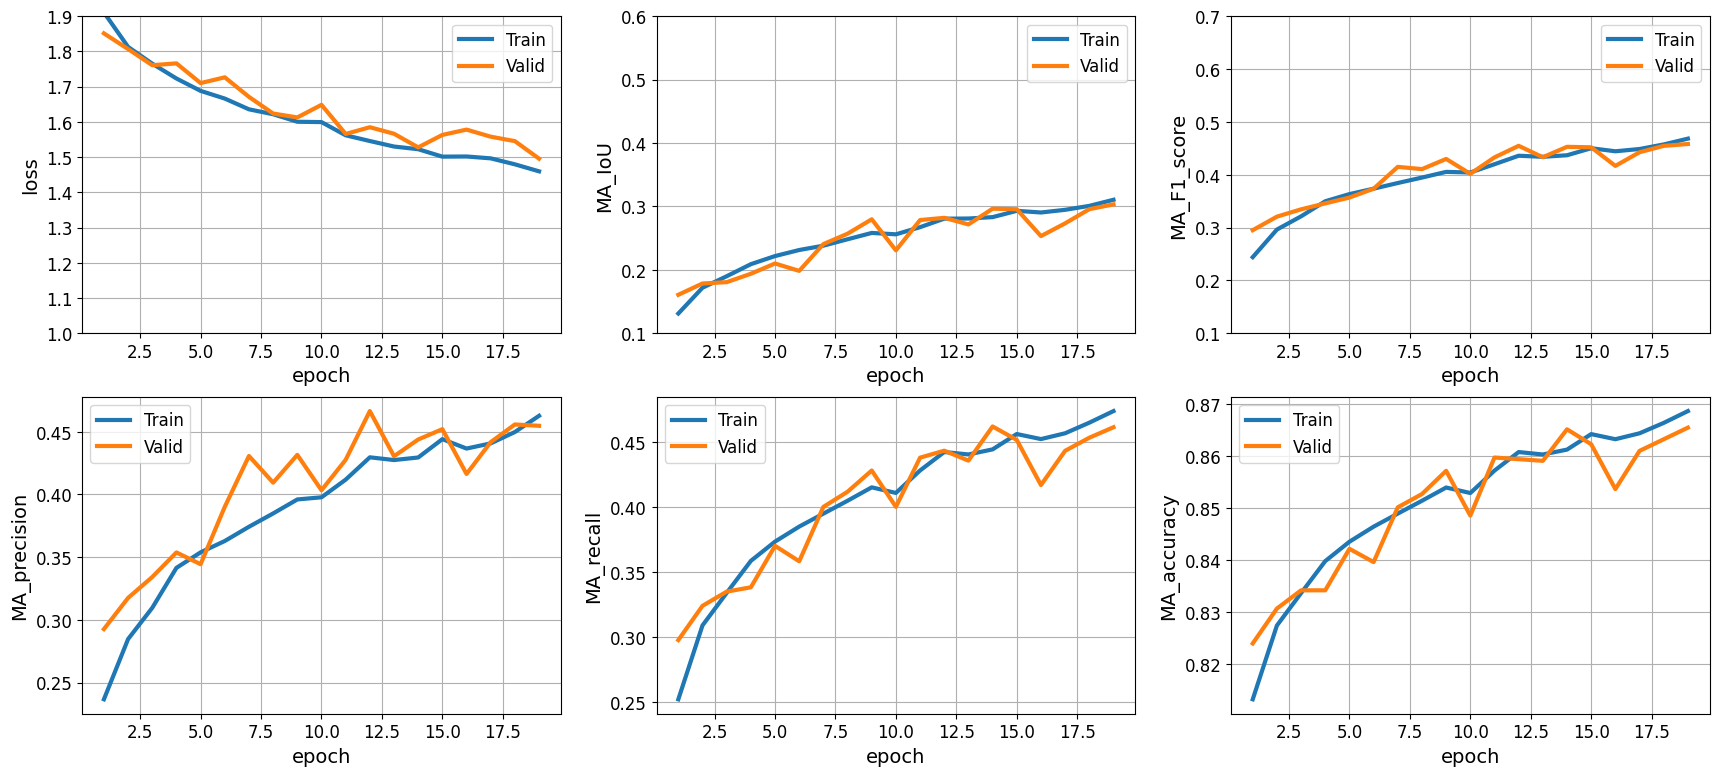

In [ ]:
plot_results(["checkpoint_Baseline_A_1D.pt", "checkpoint_Baseline_A_1D_resume.pt",],
 ["results_Baseline_A_1D.csv", "results_Baseline_A_1D_resume.csv"])

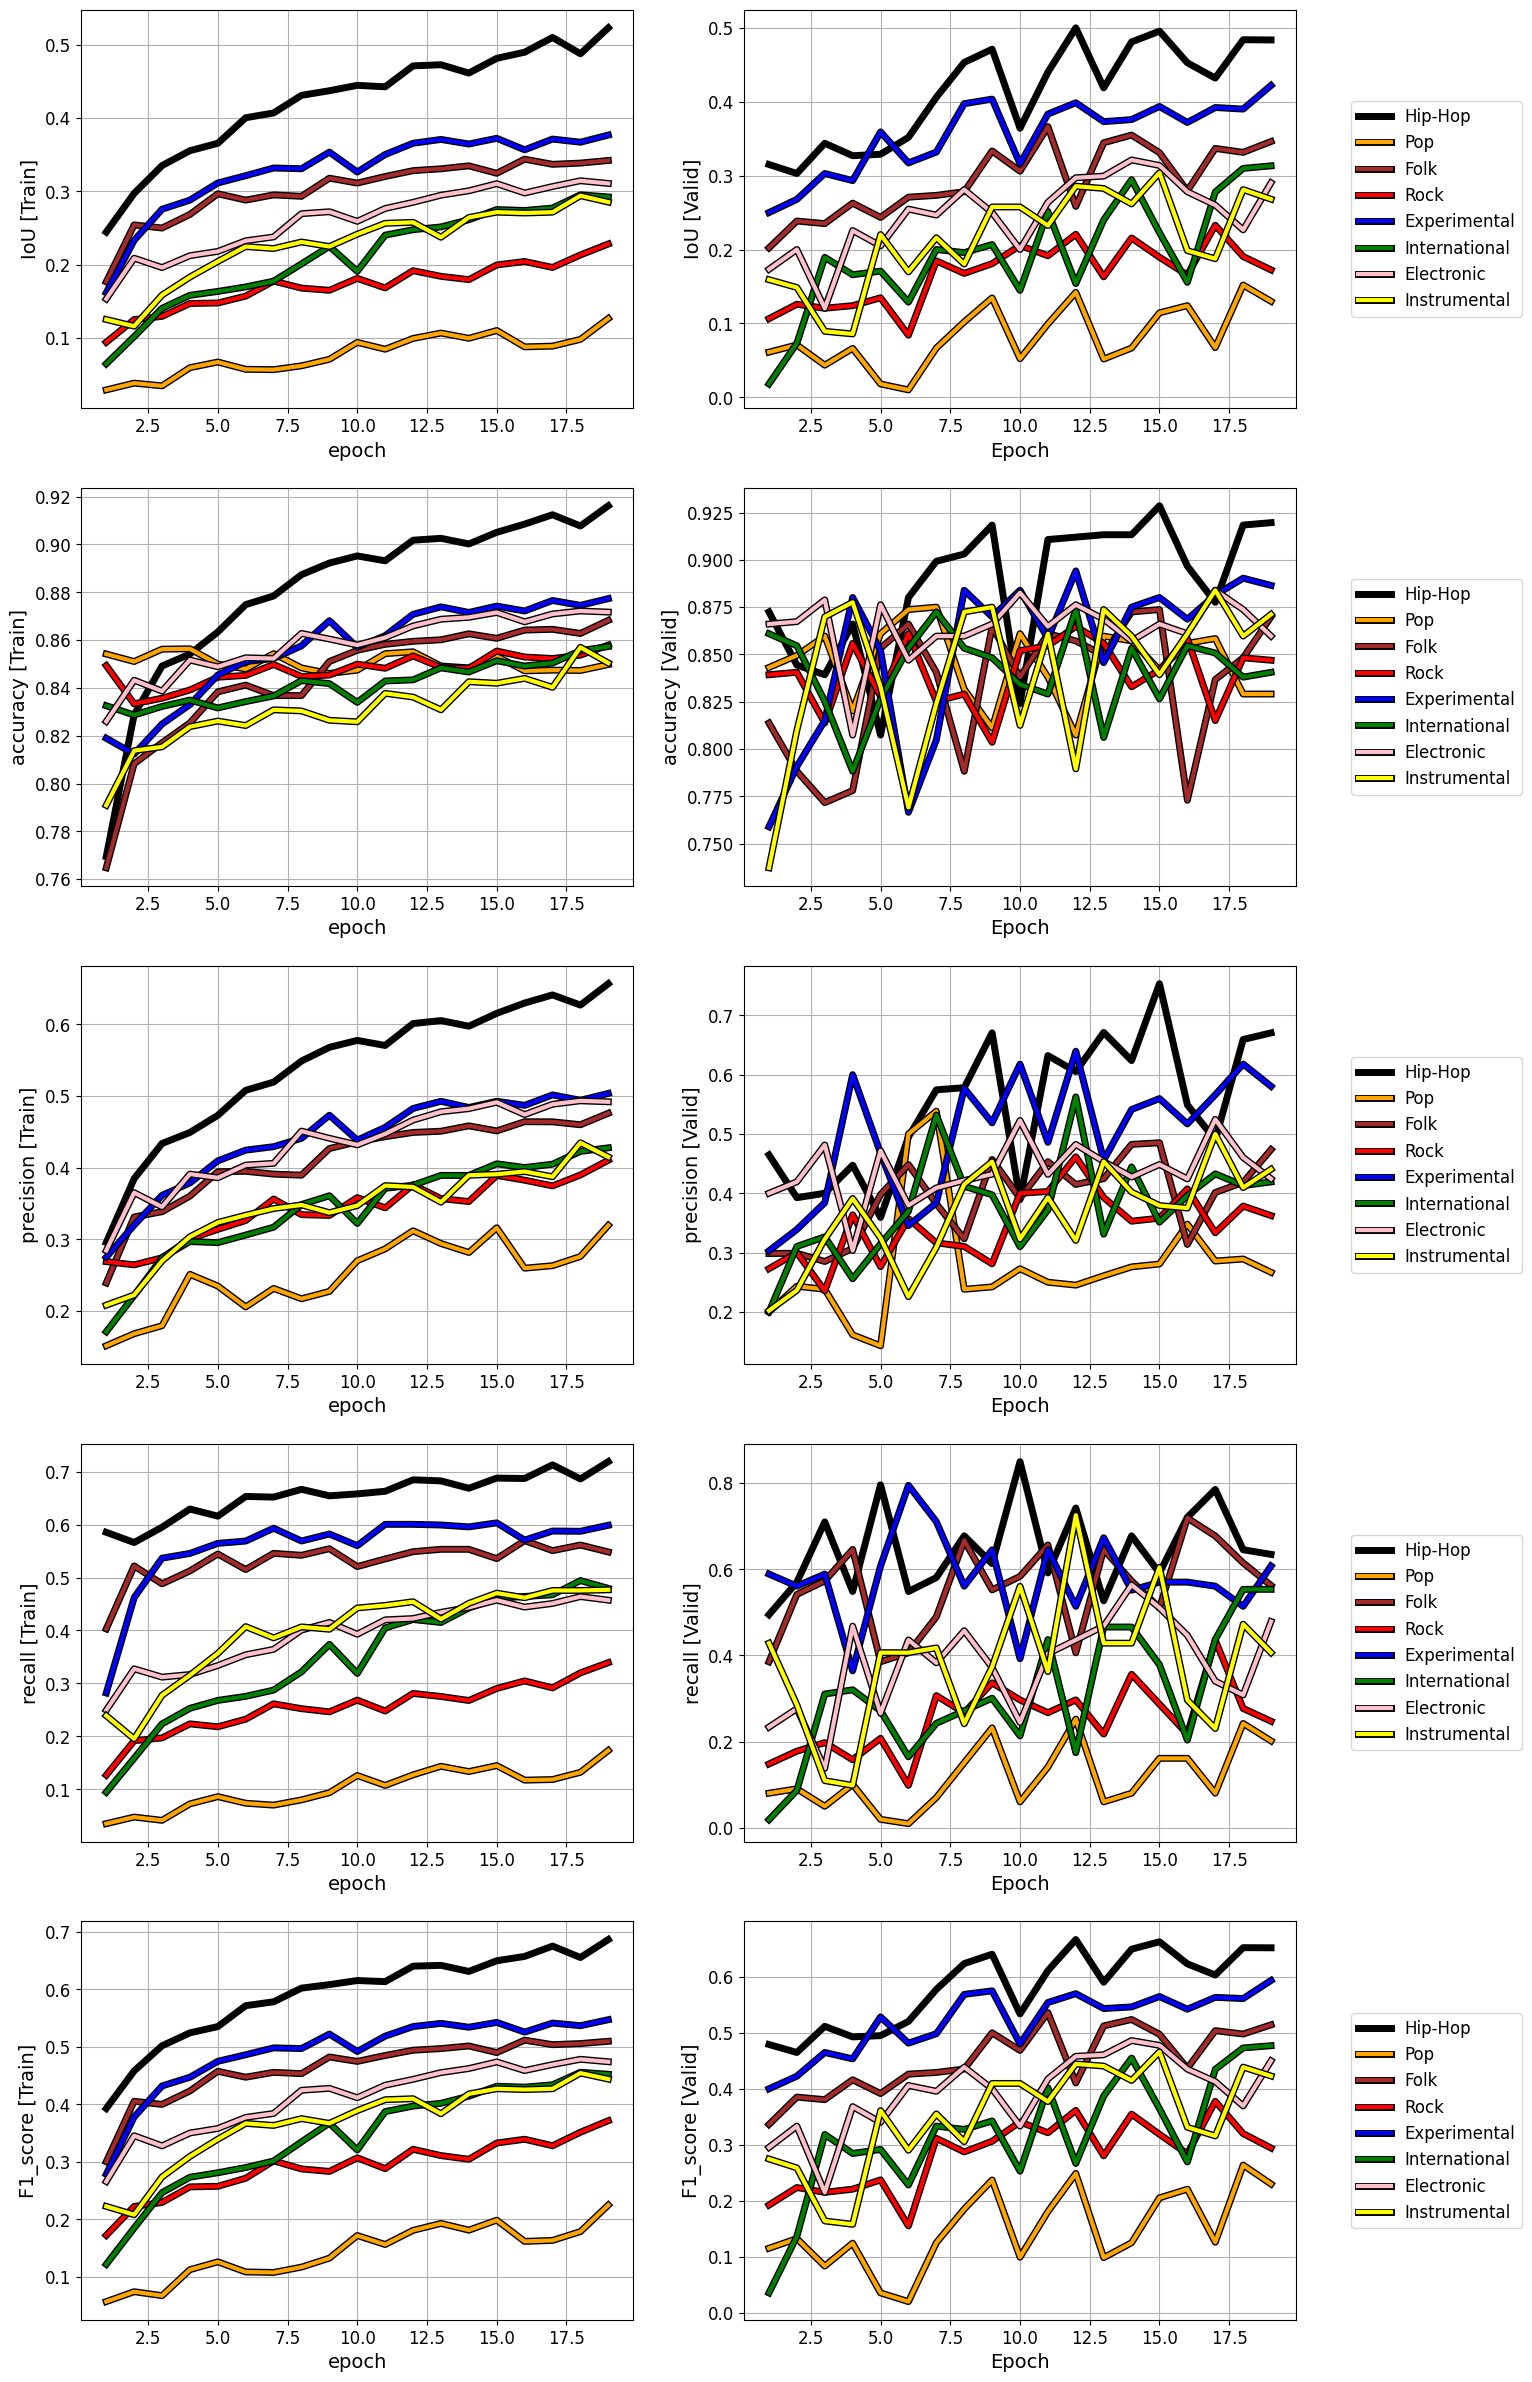

In [ ]:
plot_results_per_class(class_names, colors, ["checkpoint_Baseline_A_1D.pt", "checkpoint_Baseline_A_1D_resume.pt",],
 ["results_Baseline_A_1D.csv", "results_Baseline_A_1D_resume.csv"])

## Testing

In [ ]:
TEST = False

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion,
                  device,
                  "checkpoint_Baseline_A_1D_resume.pt",
                  "results_Baseline_A_1D_resume.csv",
                  "confusion_matrix_Baseline_A_1D_resume.csv")

In [ ]:
pd.read_csv(DATA_DIR+"/results/test_results_Baseline_A_1D_resume.csv").iloc[:,np.arange(0, 12, 2)].style.hide(axis="index")

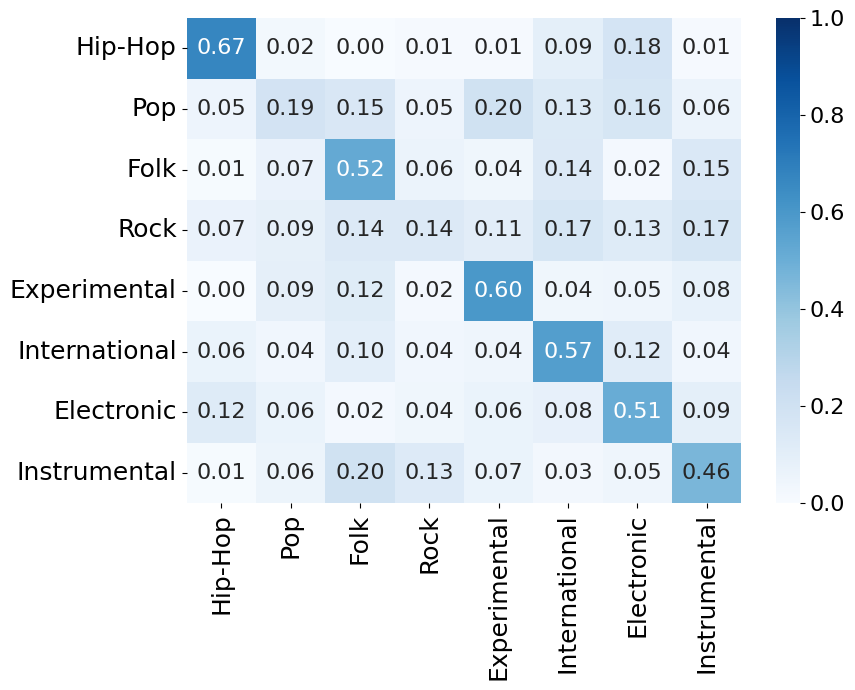

In [ ]:
plot_CM(class_names, "confusion_matrix_Baseline_A_1D_resume.csv")

# Input 2D (513X128): Baseline A and Baseline B

## Create a custom dataset class

In [ ]:
class MelDataset_128(Dataset):

    def __init__(self, df, delta_t = 10, post_transform = None, augmentation = True):

        # read track_id and the genre
        self.labels = df["top_genre_ind"].tolist()
        self.ids = df["track_id"].tolist()
        self.delta_t = int(delta_t)
        self.sr = 16000
        self.hop_lenght = int(self.delta_t*self.sr/127)
        self.n_fft = self.hop_lenght*2

        self.post_transform = post_transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):

        ind = self.ids[i]

        filename = utils.get_audio_path(DATA_DIR+'/fma_small', ind) # path and track_i

        # Time stretch
        stretch_factor = 1
        if np.random.uniform() < 0.5 and self.augmentation: stretch_factor = np.random.uniform(0.9,1.1)
        sr = self.sr*stretch_factor


        # Load track
        x, sr = librosa.load(filename, sr=sr, mono=True)
        start = np.random.randint(26-self.delta_t)
        end = start+self.delta_t
        x = x[start*self.sr:end*self.sr]


        # Add backgroundnoise
        if np.random.uniform() < 0.5 and self.augmentation:
          x_max = np.max(x)
          noise = np.random.normal(0, np.random.uniform(0, 0.03)*np.abs(x_max), len(x))
          x = x + noise

        # evaluate mel spectrogram
        stft = np.abs(librosa.stft(x, n_fft=self.n_fft, hop_length=self.hop_lenght))
        mel = librosa.feature.melspectrogram(S=stft, sr=self.sr, n_mels=513)


        # convert to dB
        mel = librosa.amplitude_to_db(mel,ref=np.max)

        # Normilize
        mean = np.mean(mel)
        std = np.std(mel)

        norm = Normalize(mean, std)


        # apply post-transformations
        if self.post_transform:
            mel = self.post_transform(mel) # ToTensor


        if std != 0 :
          mel = norm(mel) #(mel-mean)/std


        label = self.labels[i]

        # keep dense encoding -> nn.CrossEntropyLoss expects integer labels


        return mel.float(), label

In [ ]:
# get size of an element from the train dataset
idx = 0
get_size(MelDataset_128(train_df, post_transform = post_transform, augmentation = True)[idx][0])

object type:               shape:             data type:       size [Mb]:     

<class 'torch.Tensor'>     [1, 513, 128]      torch.float32    0.263         


## Create train, valid and test datasets and their iterators

In [ ]:
train_dataset = MelDataset_128(train_df, 10, post_transform, True)
valid_dataset = MelDataset_128(valid_metadata_df, 10, post_transform, False)
test_dataset = MelDataset_128(test_metadata_df, 10, post_transform, False)

In [ ]:
BATCH_SIZE = 32

# create iterators
train_iterator = DataLoader(train_dataset, shuffle = True, batch_size = BATCH_SIZE, drop_last = True)
valid_iterator = DataLoader(valid_dataset, batch_size = BATCH_SIZE, drop_last = True)
test_iterator = DataLoader(test_dataset, batch_size = BATCH_SIZE, drop_last = True)

# The drop_last=True parameter ignores the last batch (when the number of examples in your dataset is not divisible by your batch_size)

In [ ]:
# get size of an waveform from the train iterator (with transformations)
batch = next(iter(train_iterator))
get_size(batch[0])

object type:               shape:             data type:       size [Mb]:     

<class 'torch.Tensor'>     [32, 1, 513, 128]  torch.float32    8.405         


## Define the models

In [ ]:
class Baseline_A_2D(nn.Module):

    def __init__(self, genres_num = 8):
        super().__init__()

        ### Convolutional section
        self.baseline_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=(513,4),
                      stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2), padding=0),
            # Second convolutional layer
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1,4),
                      stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2), padding=0),
            # Third convolutional layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,4),
                      stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )

        self.first_right = nn.MaxPool2d(kernel_size=(1,26), stride=13, padding=0)
        self.first_left = nn.AvgPool2d(kernel_size=(1,26), stride=13, padding=0)

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.baseline_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=512, out_features=300),
            nn.ReLU(True),
            #nn.Dropout(0.2),
            # Second linear layer
            nn.Linear(in_features=300, out_features=150),
            nn.ReLU(True),
            #nn.Dropout(0.2),
            # Third linear layer
            nn.Linear(in_features=150, out_features=genres_num)
        )

    def forward(self, x):
        # Apply convolutions
        x = self.baseline_cnn(x)
        #print(x.shape)
        x_l = self.first_left(x)
        #print(x_l.shape)
        x_r = self.first_right(x)
        #print(x_r.shape)
        x = torch.cat([x_l, x_r], axis=1)
        #print(x.shape)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.baseline_lin(x)
        return x

In [ ]:
model = Baseline_A_2D(8)
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 661058


In [ ]:
class Baseline_B_2D(nn.Module):

    def __init__(self, genres_num = 8):
        super().__init__()

        ### Convolutional section
        self.first_conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(513,4),
                      stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #nn.Dropout(0.2)
            )

        self.baseline_cnn = nn.Sequential(

            # Second convolutional layer
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1,4),
                      stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #nn.Dropout(0.2),
            # Third convolutional layer
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1,4),
                      stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )

        self.first_right = nn.MaxPool2d(kernel_size=(1,125), stride=1, padding=0)
        self.first_left = nn.AvgPool2d(kernel_size=(1,125), stride=1, padding=0)

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.baseline_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=512, out_features=300),
            nn.ReLU(True),
            nn.Dropout(0.2),
            # Second linear layer
            nn.Linear(in_features=300, out_features=150),
            nn.ReLU(True),
            nn.Dropout(0.2),
            # Third linear layer
            nn.Linear(in_features=150, out_features=genres_num)
        )

    def forward(self, x):
        # Apply convolutions
        x = self.first_conv(x)
        #print(x.shape)
        y = self.baseline_cnn(x)
        #print(y.shape)
        z = x+F.pad(y, (3,3,0,0), 'constant', 0)
        #print(z.shape)
        #print(x.shape)
        x_l = self.first_left(z)
        #print(x_l.shape)
        x_r = self.first_right(z)
        #print(x_r.shape)
        x = torch.cat([x_l, x_r], axis=1)
        #print(x.shape)
        #print(x.shape)
        # Flatten
        x = self.flatten(x)
        #print(x.shape)
        # # Apply linear layers
        x = self.baseline_lin(x)
        #print(x.shape)
        return x

In [ ]:
model = Baseline_B_2D(8)
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 1252162


## Training

### Baseline_A

In [ ]:
model = Baseline_A_2D(8)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-4)

scheduler = None

N_EPOCHS = 20

In [ ]:
TRAIN = False

RESUME = False

if TRAIN:
    if RESUME:
        # load checkpoint
        model, criterion, optimizer, scheduler = load_checkpoint(model,
                                                             criterion,
                                                             optimizer,
                                                             scheduler,
                                                             checkpoint_name = "checkpoint_Baseline_A_2D.pt")


    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          "checkpoint_Baseline_A_2D.pt",
                                                          "results_Baseline_A_2D.csv")

### Plot results

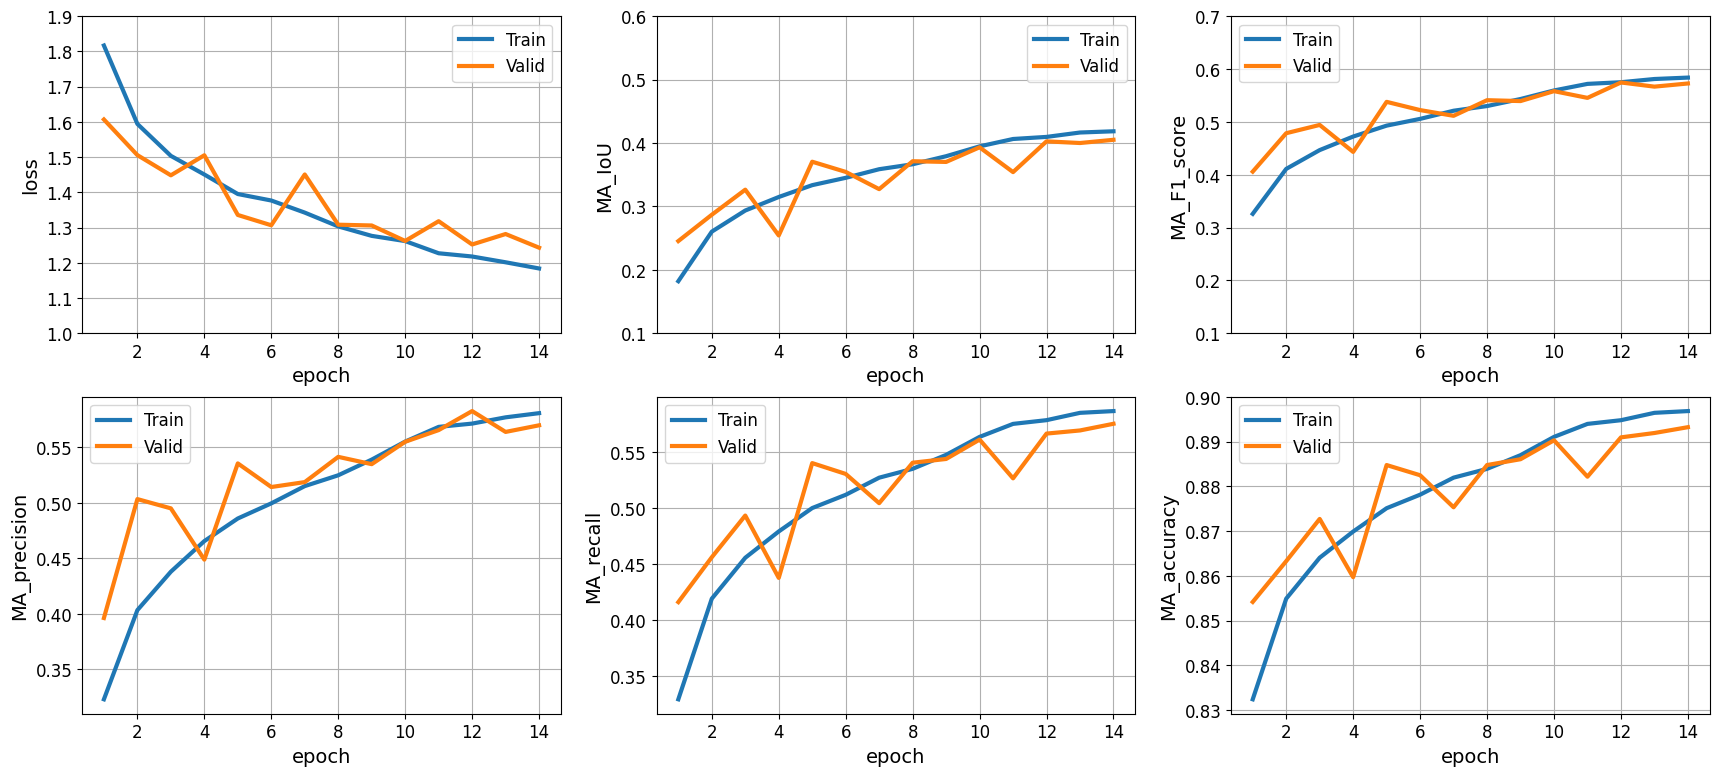

In [ ]:
plot_results(["checkpoint_Baseline_A_2D.pt", "checkpoint_Baseline_A_2D_resume_1.pt", "checkpoint_Baseline_A_2D_resume_2.pt"],
 ["results_Baseline_A_2D.csv", "results_Baseline_A_2D_resume_1.csv", "results_Baseline_A_2D_resume_2.csv"])

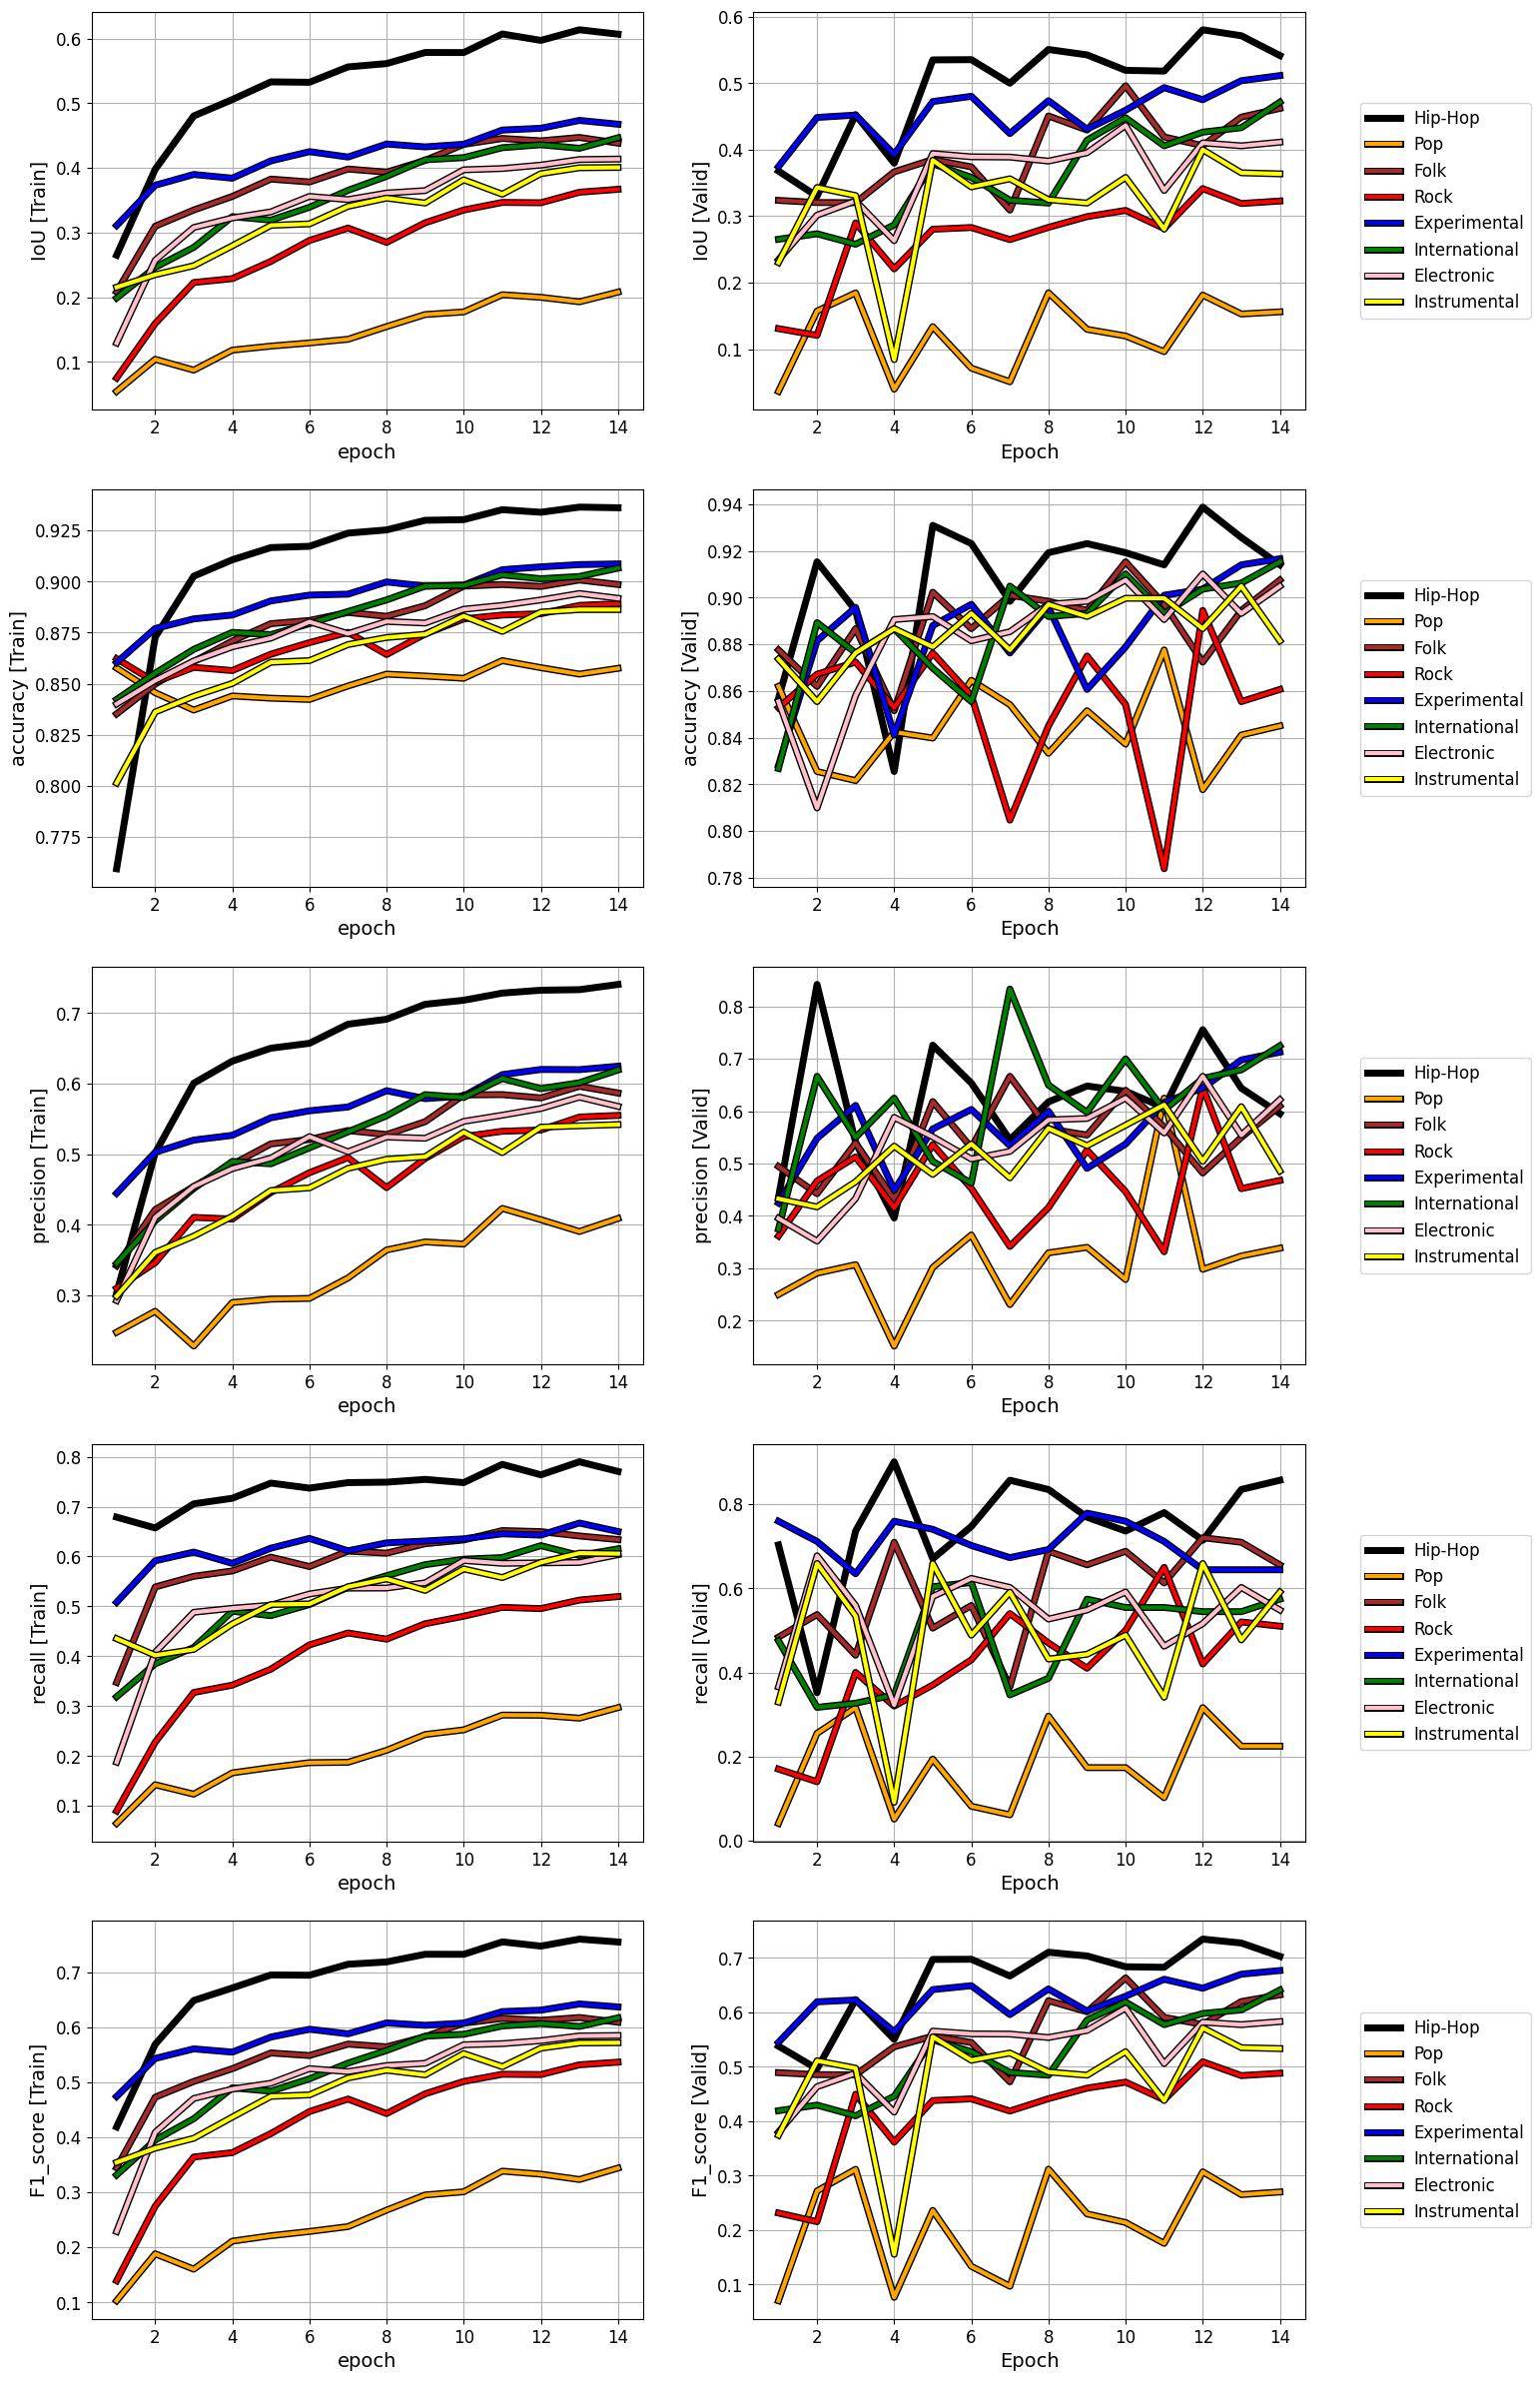

In [ ]:
plot_results_per_class(class_names, colors, ["checkpoint_Baseline_A_2D.pt", "checkpoint_Baseline_A_2D_resume_1.pt", "checkpoint_Baseline_A_2D_resume_2.pt"],
 ["results_Baseline_A_2D.csv", "results_Baseline_A_2D_resume_1.csv", "results_Baseline_A_2D_resume_2.csv"])

### Baseline_B

In [ ]:
model = Baseline_B_2D(8)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-4)

scheduler = None

N_EPOCHS = 20

In [ ]:
TRAIN = False

RESUME = False

if TRAIN:
    if RESUME:
        # load checkpoint
        model, criterion, optimizer, scheduler = load_checkpoint(model,
                                                             criterion,
                                                             optimizer,
                                                             scheduler,
                                                             checkpoint_name = "checkpoint_Baseline_B_2D.pt")


    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          "checkpoint_Baseline_B_2D.pt",
                                                          "results_Baseline_B_2D.csv")

### Plot results

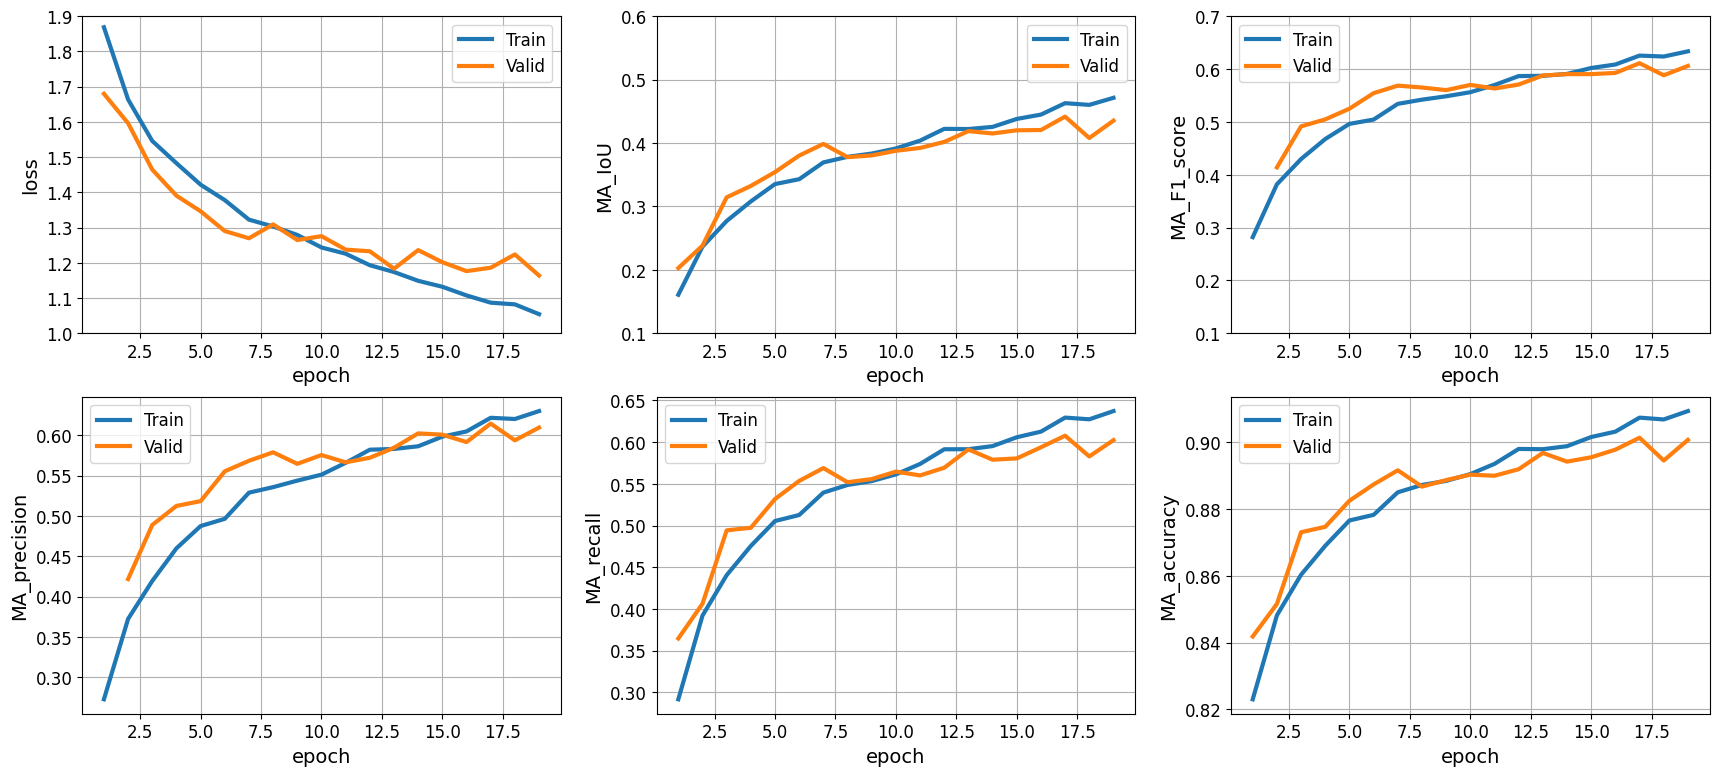

In [ ]:
plot_results(["checkpoint_Baseline_B_2D.pt", "checkpoint_Baseline_B_2D_resume_1.pt", 'checkpoint_Baseline_B_2D_resume_2.pt'],
 ["results_Baseline_B_2D.csv", "results_Baseline_B_2D_resume_1.csv", "results_Baseline_B_2D_resume_2.csv"])

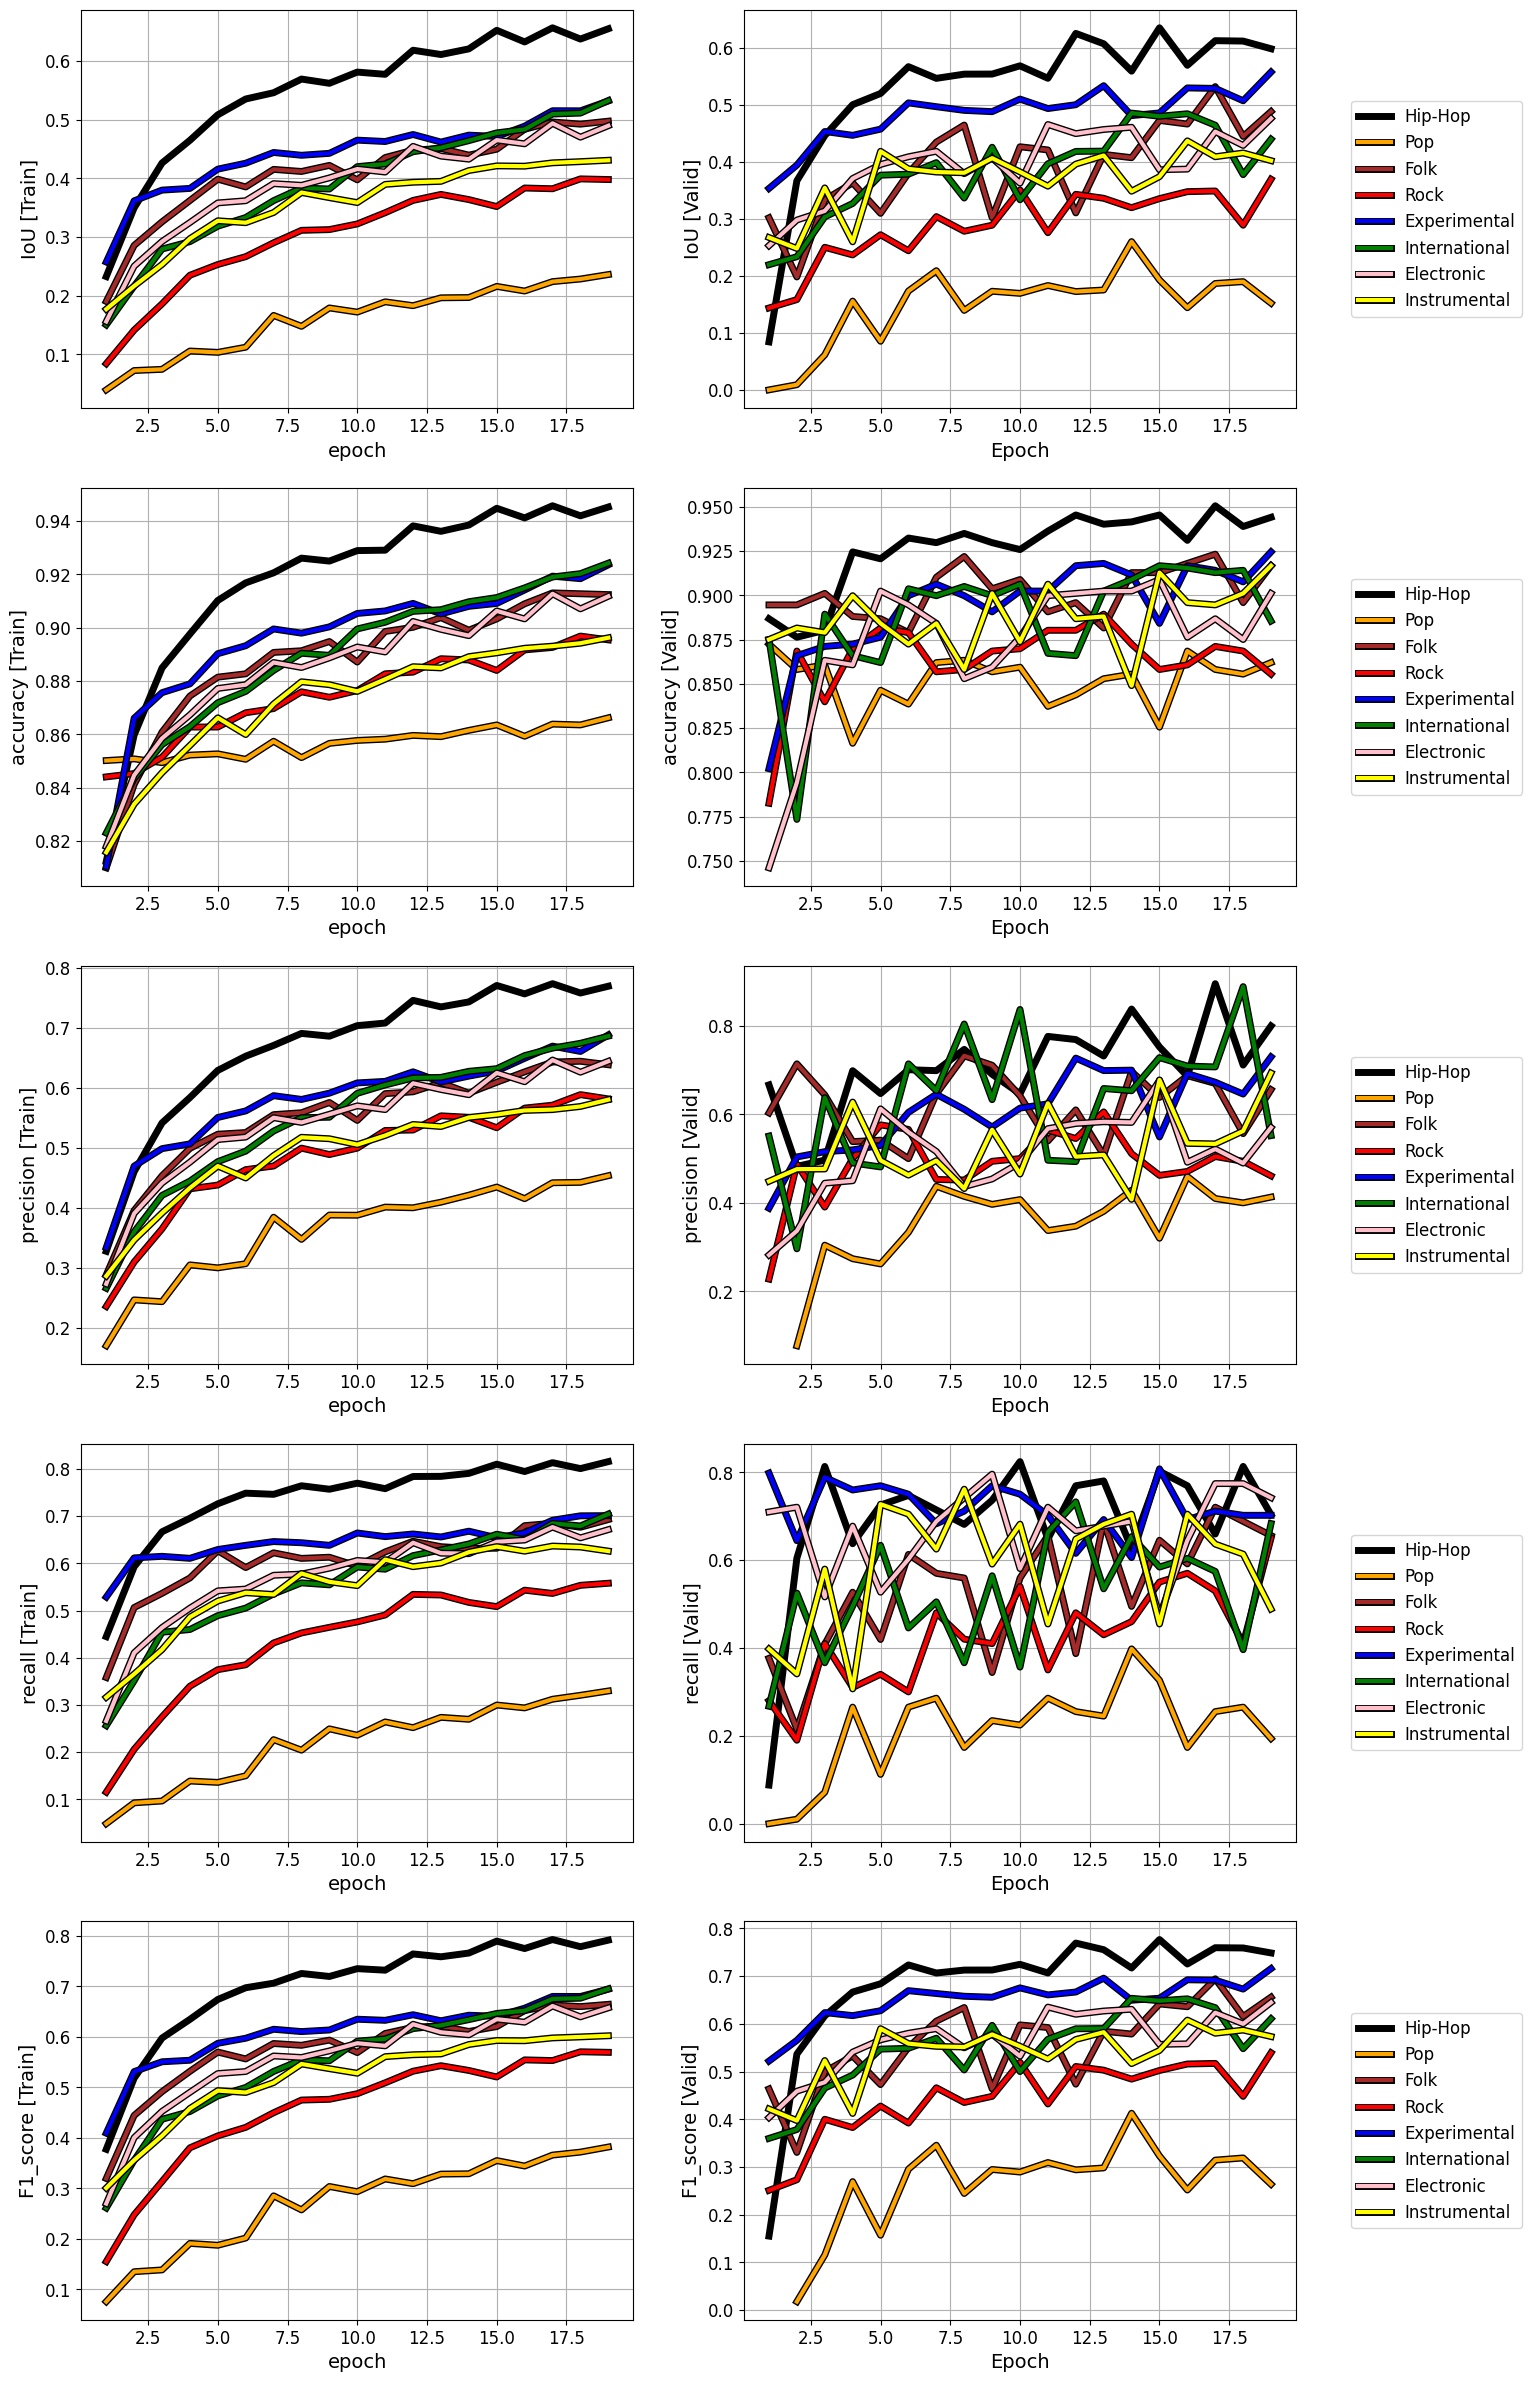

In [ ]:
plot_results_per_class(class_names, colors, ["checkpoint_Baseline_B_2D.pt", "checkpoint_Baseline_B_2D_resume_1.pt", 'checkpoint_Baseline_B_2D_resume_2.pt'],
 ["results_Baseline_B_2D.csv", "results_Baseline_B_2D_resume_1.csv", "results_Baseline_B_2D_resume_2.csv"])

## Testing

### Baseline_A

In [ ]:
TEST = False

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion,
                  device,
                  "checkpoint_Baseline_A_2D_resume_2.pt",
                  "results_Baseline_A_2D_resume_2.csv",
                  "confusion_matrix_Baseline_A_2D_resume_2.csv")

In [ ]:
pd.read_csv(DATA_DIR+"/results/test_results_Baseline_A_2D_resume_2.csv").iloc[:,np.arange(0, 12, 2)].style.hide(axis="index")

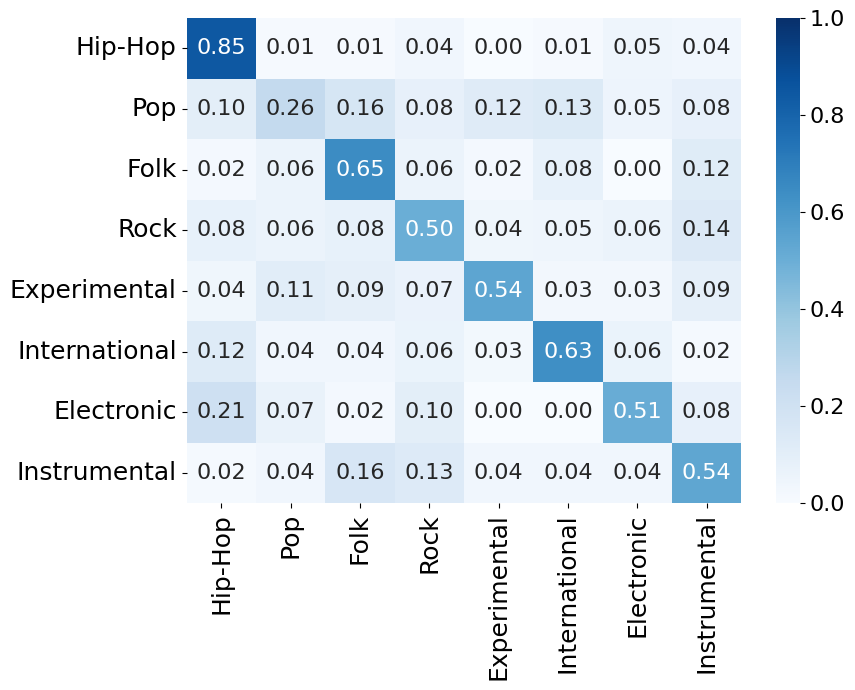

In [ ]:
plot_CM(class_names, "confusion_matrix_Baseline_A_2D_resume_2.csv")

### Baseline_B

In [ ]:
TEST = False

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion,
                  device,
                  "checkpoint_Baseline_B_2D_resume_3.pt",
                  "results_Baseline_B_2D_resume_3.csv",
                  "confusion_matrix_Baseline_B_2D_resume_3.csv")

In [ ]:
pd.read_csv(DATA_DIR+"/results/test_results_Baseline_B_2D_resume_2.csv").iloc[:,np.arange(0, 12, 2)].style.hide(axis="index")

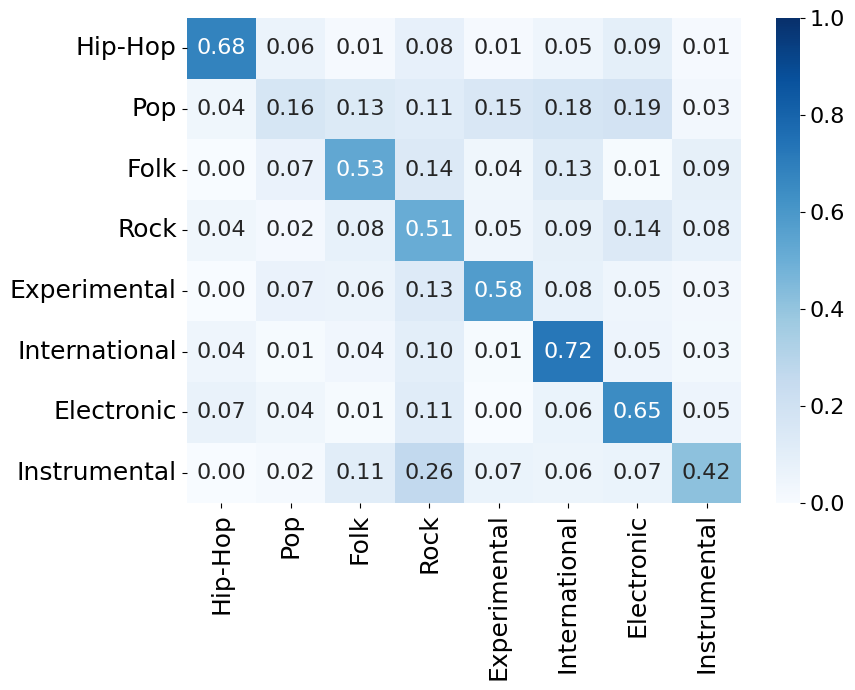

In [ ]:
plot_CM(class_names, "confusion_matrix_Baseline_B_2D_resume_2.csv")

# Input 2D (224x224): Densenet

## Create a custom dataset class

In [ ]:
class MelDataset_224(Dataset):

    def __init__(self, df, delta_t = 10, post_transform = None, augmentation = True):

        # read track_id and the genre
        self.labels = df["top_genre_ind"].tolist()
        self.ids = df["track_id"].tolist()
        self.delta_t = int(delta_t)
        self.sr = 16000
        self.hop_lenght = int(self.delta_t*self.sr/223)
        self.n_fft = self.hop_lenght*2

        self.post_transform = post_transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):

        ind = self.ids[i]

        filename = utils.get_audio_path(DATA_DIR+'/fma_small', ind) # path and track_i

        # Time stretch
        stretch_factor = 1
        if np.random.uniform() < 0.5 and self.augmentation: stretch_factor = np.random.uniform(0.9,1.1)
        sr = self.sr*stretch_factor


        # Load track
        x, sr = librosa.load(filename, sr=sr, mono=True)
        start = np.random.randint(26-self.delta_t)
        end = start+self.delta_t
        x = x[start*self.sr:end*self.sr]


        # Add backgroundnoise
        if np.random.uniform() < 0.5 and self.augmentation:
          x_max = np.max(x)
          noise = np.random.normal(0, np.random.uniform(0, 0.03)*np.abs(x_max), len(x))
          x = x + noise

        # evaluate mel spectrogram
        stft = np.abs(librosa.stft(x, n_fft=self.n_fft, hop_length=self.hop_lenght))
        mel = librosa.feature.melspectrogram(S=stft, sr=self.sr, n_mels=224)


        # convert to dB
        mel = librosa.amplitude_to_db(mel,ref=np.max)

        # Normilize
        mean = np.mean(mel)
        std = np.std(mel)

        norm = Normalize(mean, std)


        # apply post-transformations
        if self.post_transform:
            mel = self.post_transform(mel) # ToTensor


        if std != 0 :
          mel = norm(mel) #(mel-mean)/std


        label = self.labels[i]

        # keep dense encoding -> nn.CrossEntropyLoss expects integer labels


        return mel.float(), label

In [ ]:
# get size of an element from the train dataset
idx = 0
get_size(MelDataset_224(train_df, post_transform = post_transform, augmentation = True)[idx][0])

object type:               shape:             data type:       size [Mb]:     

<class 'torch.Tensor'>     [1, 224, 224]      torch.float32    0.201         


## Create train, valid and test datasets and their iterators

In [ ]:
train_dataset = MelDataset_224(train_df, 10, post_transform, True)
valid_dataset = MelDataset_224(valid_metadata_df, 10, post_transform, False)
test_dataset = MelDataset_224(test_metadata_df, 10, post_transform, False)

In [ ]:
BATCH_SIZE = 32

# create iterators
train_iterator = DataLoader(train_dataset, shuffle = True, batch_size = BATCH_SIZE, drop_last = True)
valid_iterator = DataLoader(valid_dataset, batch_size = BATCH_SIZE, drop_last = True)
test_iterator = DataLoader(test_dataset, batch_size = BATCH_SIZE, drop_last = True)

# The drop_last=True parameter ignores the last batch (when the number of examples in your dataset is not divisible by your batch_size)

In [ ]:
# get size of an waveform from the train iterator (with transformations)
batch = next(iter(train_iterator))
get_size(batch[0])

object type:               shape:             data type:       size [Mb]:     

<class 'torch.Tensor'>     [32, 1, 224, 224]  torch.float32    6.423         


## Define the model

In [ ]:
# import densenet121 not pretrained
densenet = torchvision.models.densenet121(pretrained=False)#weights=None)

# modify first layer in order to accept single channel input
densenet.features[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# modify last layer in order to consider 8 classes
num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs, 8)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# show the architecture
print(densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
model = densenet
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 6955784


## Training

In [ ]:
model = densenet
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-4)

scheduler = None

N_EPOCHS = 20

In [ ]:
TRAIN = False

RESUME = False

if TRAIN:
    if RESUME:
        # load checkpoint
        model, criterion, optimizer, scheduler = load_checkpoint(model,
                                                             criterion,
                                                             optimizer,
                                                             scheduler,
                                                             checkpoint_name = "checkpoint_Densenet.pt")


    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          "checkpoint_Densenet.pt",
                                                          "results_Densenet.csv")

### Plot results

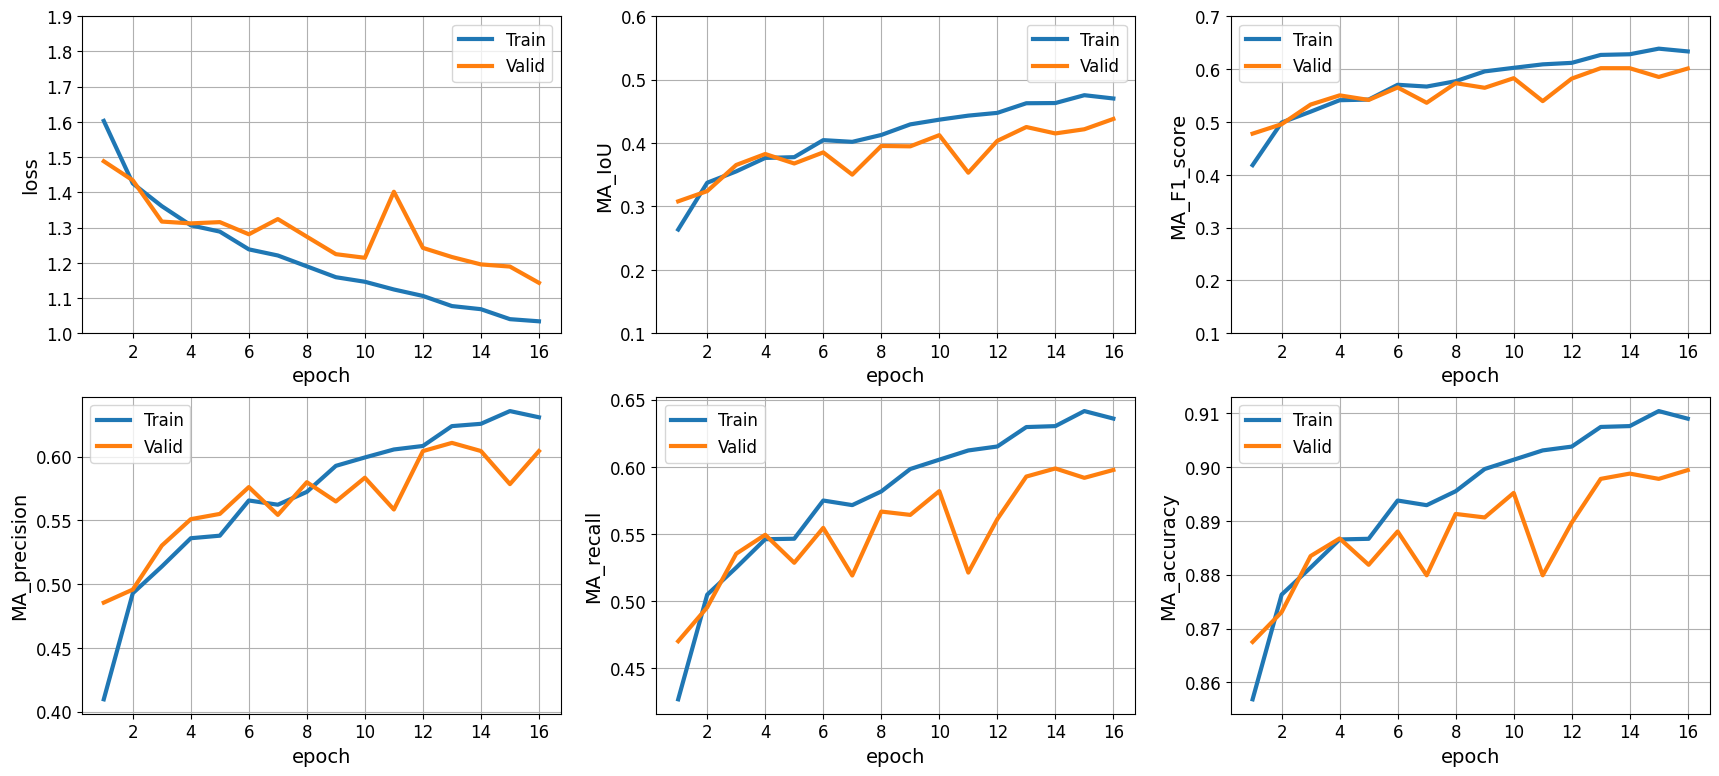

In [ ]:
plot_results(["checkpoint_Densenet.pt", "checkpoint_Densenet_resume_1.pt", 'checkpoint_Densenet_resume_2.pt'],
 ["results_Densenet.csv", "results_Densenet_resume_1.csv", "results_Densenet_resume_2.csv"])

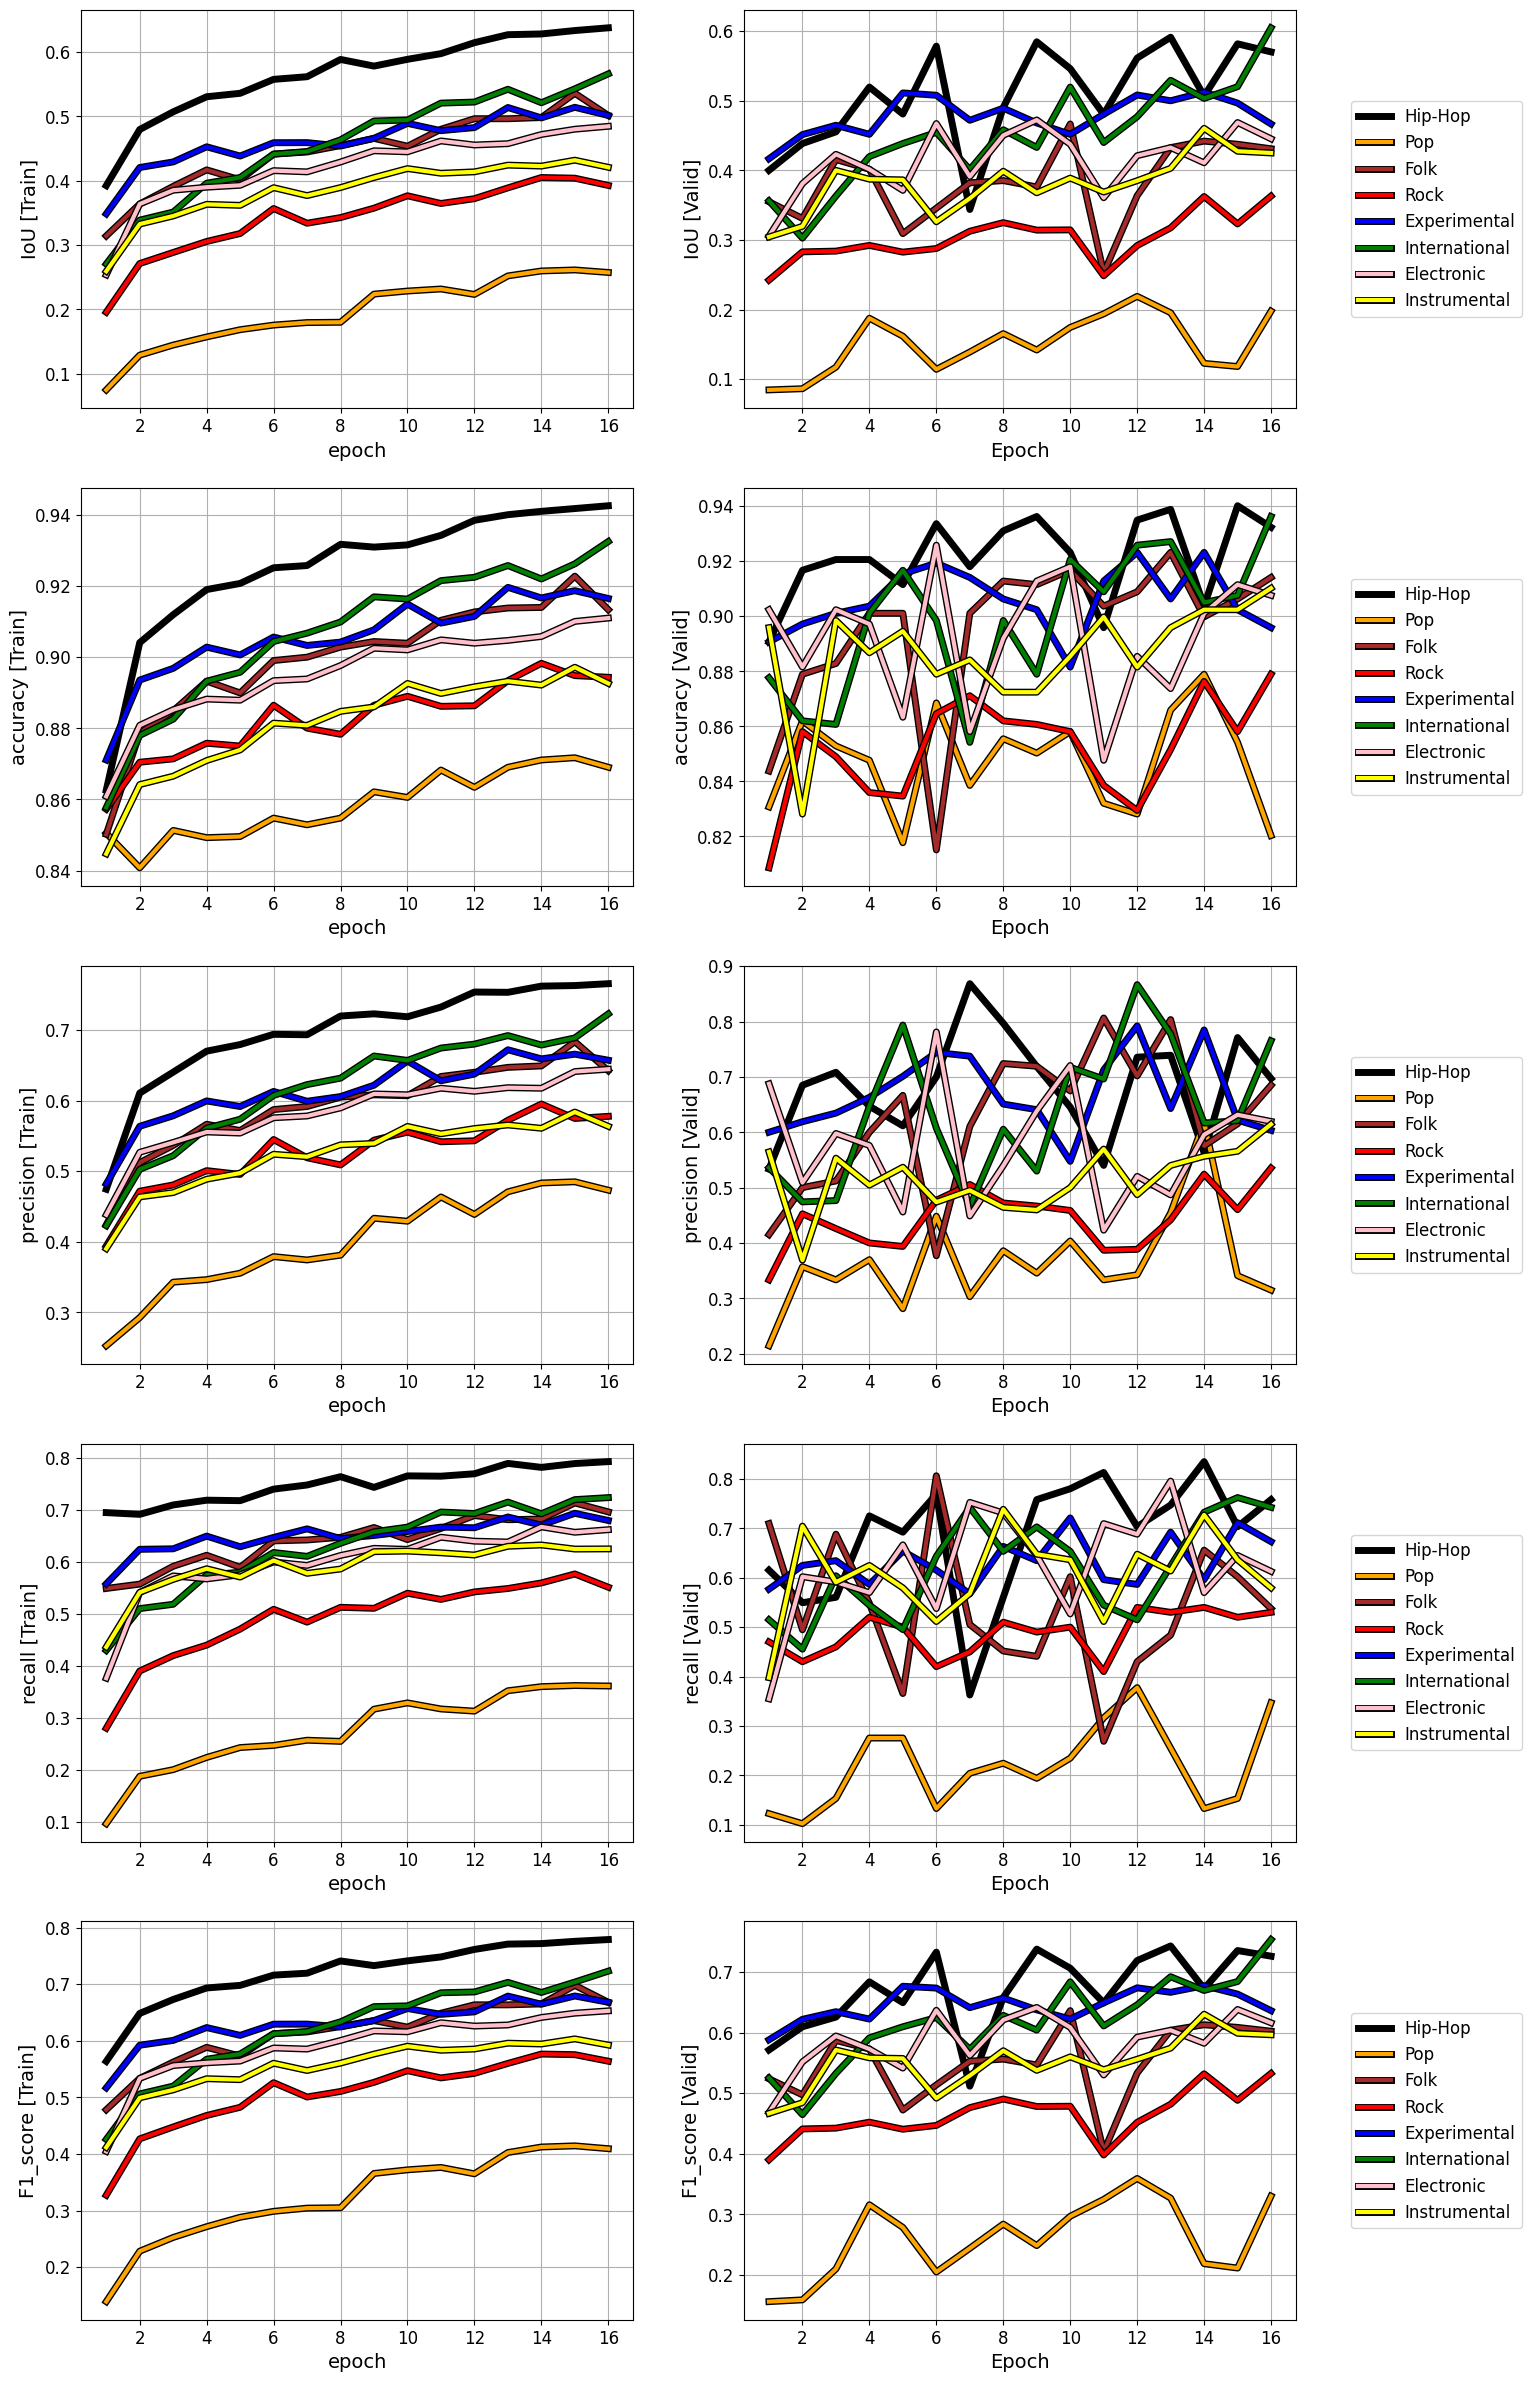

In [ ]:
plot_results_per_class(class_names, colors, ["checkpoint_Densenet.pt", "checkpoint_Densenet_resume_1.pt", 'checkpoint_Densenet_resume_2.pt'],
 ["results_Densenet.csv", "results_Densenet_resume_1.csv", "results_Densenet_resume_2.csv"])

## Testing

In [ ]:
TEST = False

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion,
                  device,
                  "checkpoint_Densenet_resume_2.pt",
                  "results_Densenet_resume_2.csv",
                  "confusion_matrix_Densenet_resume_2.csv")

In [ ]:
pd.read_csv(DATA_DIR+"/results/test_results_Densenet_resume_2.csv").iloc[:,np.arange(0, 12, 2)].style.hide(axis="index")

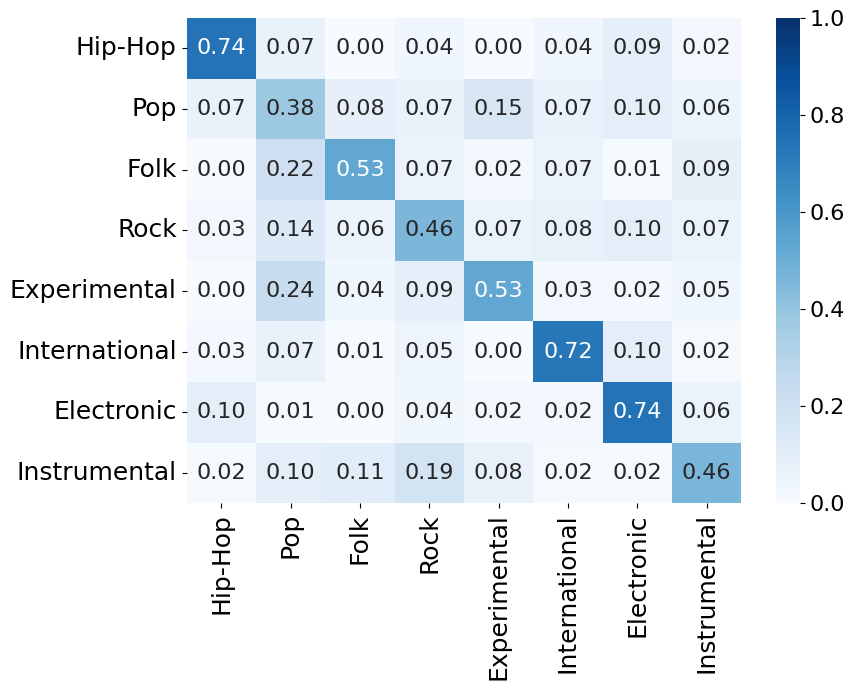

In [ ]:
plot_CM(class_names, "confusion_matrix_Densenet_resume_2.csv")

# Input 2D (224x224) and 1D: Fusion net

## Create a custom dataset class

In [ ]:
class FusionDataset(Dataset):

    def __init__(self, df, mean_1D, std_1D, delta_t = 10, post_transform = None, augmentation = True):

        # read track_id and the genre
        self.labels = df["top_genre_ind"].tolist()
        self.ids = df["track_id"].tolist()
        self.delta_t = int(delta_t)
        self.sr = 16000
        self.hop_lenght = int(self.delta_t*self.sr/223)
        self.n_fft = self.hop_lenght*2

        self.mean_1D = mean_1D
        self.std_1D = std_1D

        self.post_transform = post_transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):

        ind = self.ids[i]

        filename = utils.get_audio_path(DATA_DIR+'/fma_small', ind) # path and track_i

        # Time stretch
        stretch_factor = 1
        if np.random.uniform() < 0.5 and self.augmentation: stretch_factor = np.random.uniform(0.9,1.1)
        sr = self.sr*stretch_factor


        # Load track
        x, sr = librosa.load(filename, sr=sr, mono=True)
        start = np.random.randint(26-self.delta_t)
        end = start+self.delta_t
        x = x[start*self.sr:end*self.sr]


        # Add backgroundnoise
        if np.random.uniform() < 0.5 and self.augmentation:
          x_max = np.max(x)
          noise = np.random.normal(0, np.random.uniform(0, 0.03)*np.abs(x_max), len(x))
          x = x + noise



        # Evaluate mel spectrogram 2D
        stft = np.abs(librosa.stft(x, n_fft=self.n_fft, hop_length=self.hop_lenght))
        mel = librosa.feature.melspectrogram(S=stft, sr=self.sr, n_mels=224)


        # convert to dB
        mel = librosa.amplitude_to_db(mel,ref=np.max)

        # Normalize 2D
        mean_2D = np.mean(mel)
        std_2D = np.std(mel)

        norm2D = Normalize(mean_2D, std_2D)


        # apply post-transformations
        if self.post_transform:
            mel = self.post_transform(mel) # ToTensor

        x = torch.from_numpy(x.reshape(1,-1)) # ToTensor



        if std_2D != 0 :
          mel = norm2D(mel) #(mel-mean)/std


        # Normalize 1D
        x = (x-self.mean_1D)/self.std_1D


        label = self.labels[i]


        # keep dense encoding -> nn.CrossEntropyLoss expects integer labels

        return [x.float(), mel.float()], label

In [ ]:
# get size of an element from the train dataset
idx = 0
get_size(FusionDataset(train_df, mean_1D = train_mean, std_1D = train_std, post_transform = post_transform, augmentation = True)[idx][0][0])

object type:               shape:             data type:       size [Mb]:     

<class 'torch.Tensor'>     [1, 160000]        torch.float32    0.64          


## Create train, valid and test datasets and their iterators

In [ ]:
train_dataset = FusionDataset(train_df, train_mean, train_std, 10, post_transform, True)
valid_dataset = FusionDataset(valid_metadata_df, train_mean, train_std, 10, post_transform, False)
test_dataset = FusionDataset(test_metadata_df, train_mean, train_std, 10, post_transform, False)

In [ ]:
BATCH_SIZE = 8

# create iterators
train_iterator = DataLoader(train_dataset, shuffle = True, batch_size = BATCH_SIZE, drop_last = True)
valid_iterator = DataLoader(valid_dataset, batch_size = BATCH_SIZE, drop_last = True)
test_iterator = DataLoader(test_dataset, batch_size = BATCH_SIZE, drop_last = True)

# The drop_last=True parameter ignores the last batch (when the number of examples in your dataset is not divisible by your batch_size)

In [ ]:
# get size of an image and a mask from the train iterator (with transformations)
batch = next(iter(train_iterator))
get_size(batch[0][0])

object type:               shape:             data type:       size [Mb]:     

<class 'torch.Tensor'>     [8, 1, 160000]     torch.float32    5.12          


## Define the model

In [ ]:
# import densenet121 not pretrained
densenet = torchvision.models.densenet121(weights=None)

# modify first layer in order to accept single channel input
densenet.features[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# modify last layer in order to remove the classificator
num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Identity()

In [ ]:
class audionet(nn.Module):

    def __init__(self):
        super().__init__()

        ### Convolutional section
        self.baseline_cnn = nn.Sequential(

            # first convolutional block
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=256, stride=64, padding=128),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=4, stride=4, padding=0),

            # second convolutional block
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=32, stride=2, padding=16),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0),

            # third convolutional block
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=16, stride=2, padding=8),
        )


        self.first_right = nn.MaxPool1d(kernel_size=32, stride=6, padding=0)
        self.first_left = nn.AvgPool1d(kernel_size=32, stride=6, padding=0)

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)



    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv1d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()


    def forward(self, x):
        x = self.baseline_cnn(x)
        #print(x.shape)
        x_l = self.first_left(x)
        #print(x_l.shape)
        x_r = self.first_right(x)
        #print(x_r.shape)
        x = torch.cat([x_l, x_r], axis=1)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        return x

In [ ]:
class Fusion(nn.Module):

    def __init__(self, genres_num = 8):
        super().__init__()
        # Densenet121
        self.densenet = densenet
        # Audionet
        self.audionet = audionet()

        # Fusion
        self.fusion = nn.Sequential(

            # first linear block
            nn.Linear(in_features=2048, out_features=256),
            nn.ReLU(True),
            nn.Dropout(0.2),

            # second linear block
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(True),
            nn.Dropout(0.2),

            # final linear layer
            nn.Linear(in_features=64, out_features=genres_num)
        )

    def forward(self, x):

        x_1d, x_2d = x

        # Densenet
        x_2d = densenet(x_2d)

        # Audionet
        x_1d = self.audionet(x_1d)

        # Concatenation
        x_lin = torch.cat([x_1d, x_2d], dim = 1)

        # fusion
        return self.fusion(x_lin)

In [ ]:
model = Fusion(8)
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 7542552


## Training

In [ ]:
model = Fusion(8)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-4)

scheduler = None

N_EPOCHS = 20

In [ ]:
TRAIN = False

RESUME = False

if TRAIN:
    if RESUME:
        # load checkpoint
        model, criterion, optimizer, scheduler = load_checkpoint(model,
                                                             criterion,
                                                             optimizer,
                                                             scheduler,
                                                             checkpoint_name = "checkpoint_Fusion.pt")


    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          "checkpoint_Fusion.pt",
                                                          "results_Fusion.csv")

### Plot results

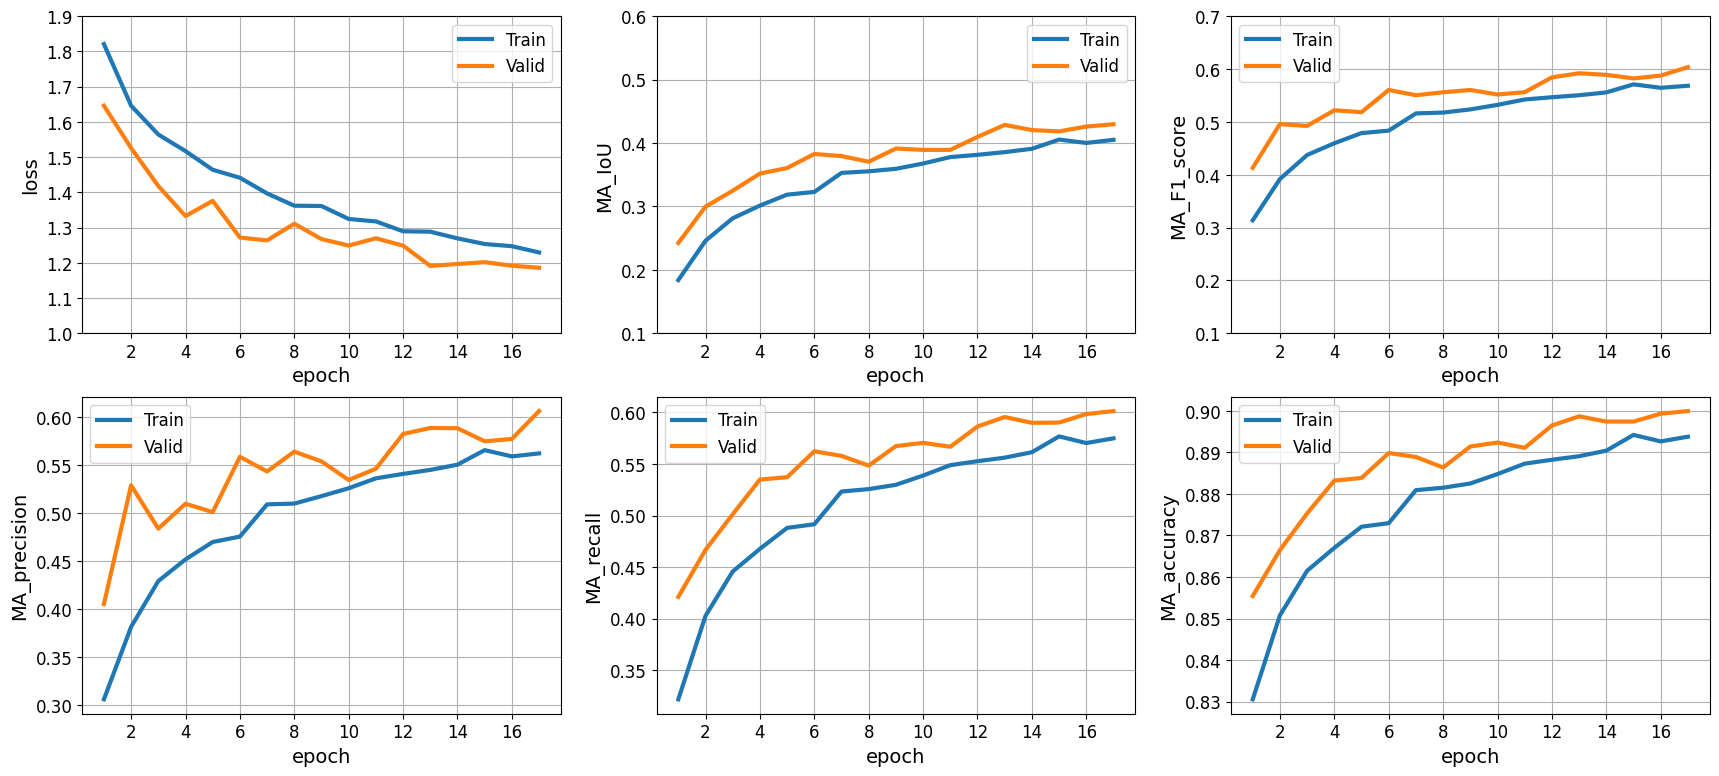

In [ ]:
plot_results(["checkpoint_Fusion.pt", "checkpoint_Fusion_resume_1.pt", 'checkpoint_Fusion_resume_2.pt'],
 ["results_Fusion.csv", "results_Fusion_resume_1.csv", "results_Fusion_resume_2.csv"])

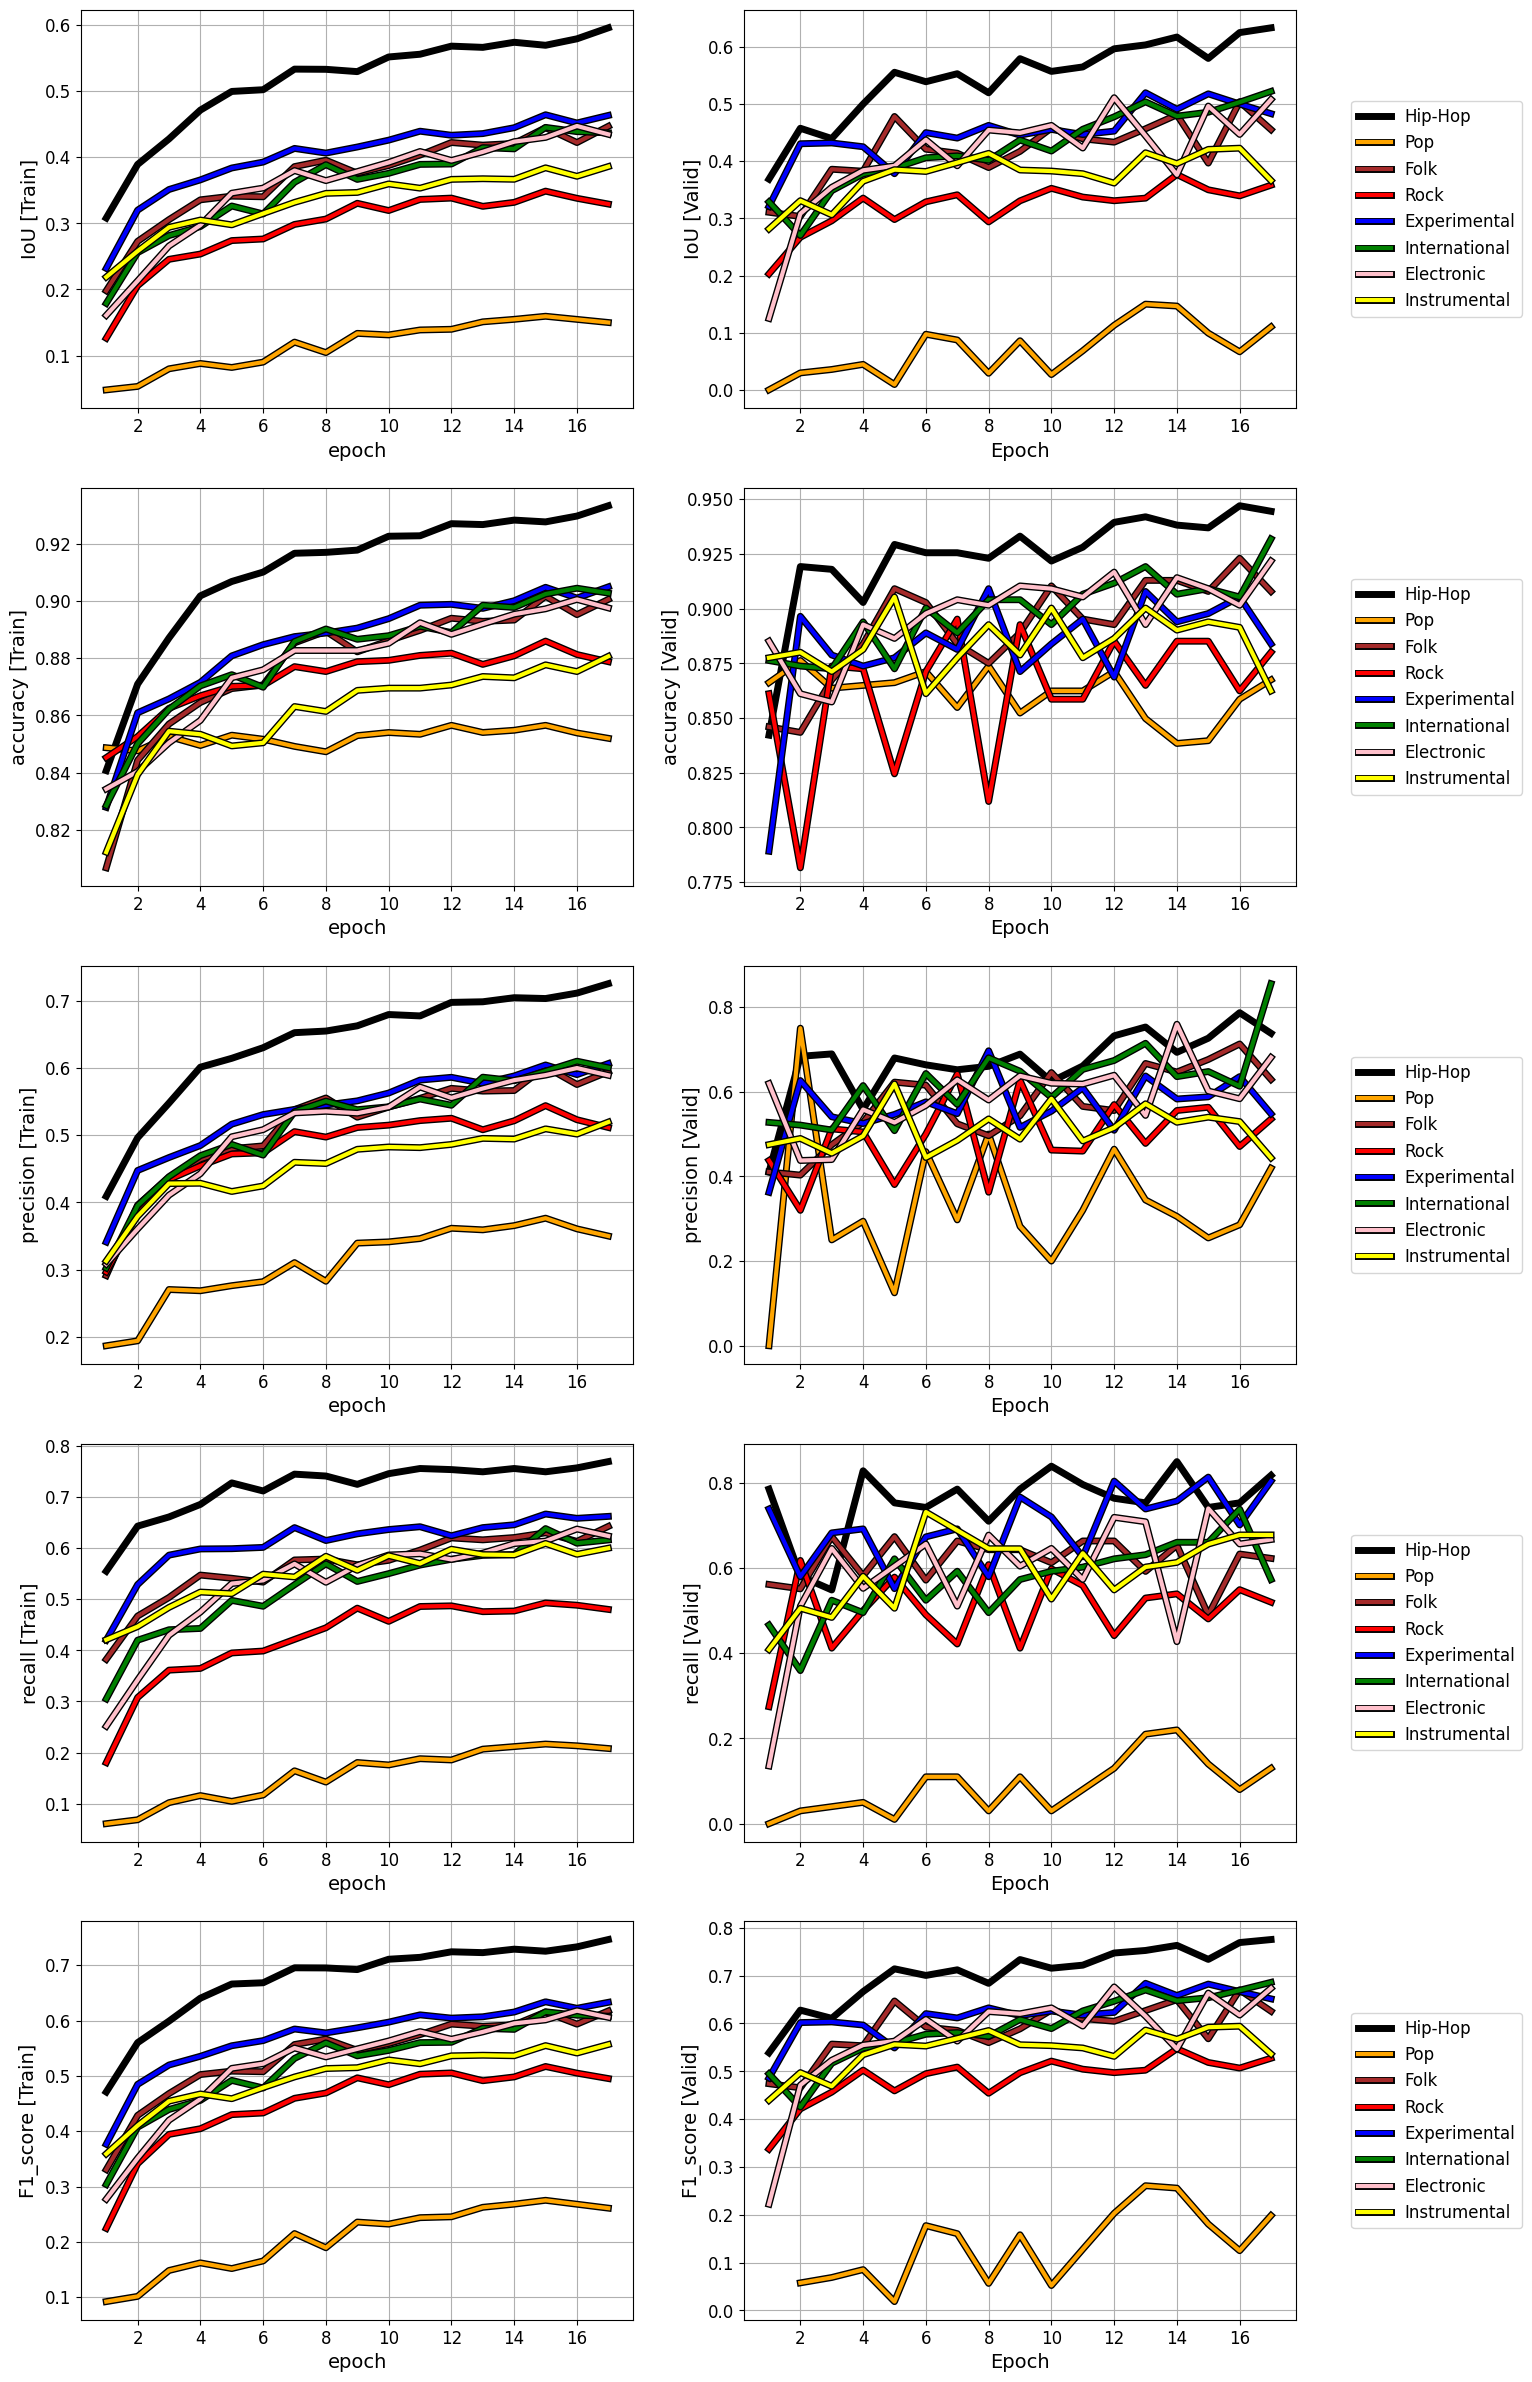

In [ ]:
plot_results_per_class(class_names, colors, ["checkpoint_Fusion.pt", "checkpoint_Fusion_resume_1.pt", 'checkpoint_Fusion_resume_2.pt'],
 ["results_Fusion.csv", "results_Fusion_resume_1.csv", "results_Fusion_resume_2.csv"])

## Testing

In [ ]:
TEST = False

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion,
                  device,
                  "checkpoint_Fusion_resume_2.pt",
                  "results_Fusion_resume_2.csv",
                  "confusion_matrix_Fusion_resume_2.csv")

In [ ]:
pd.read_csv(DATA_DIR+"/results/test_results_Fusion_resume_2.csv").iloc[:,np.arange(0, 12, 2)].style.hide(axis="index")

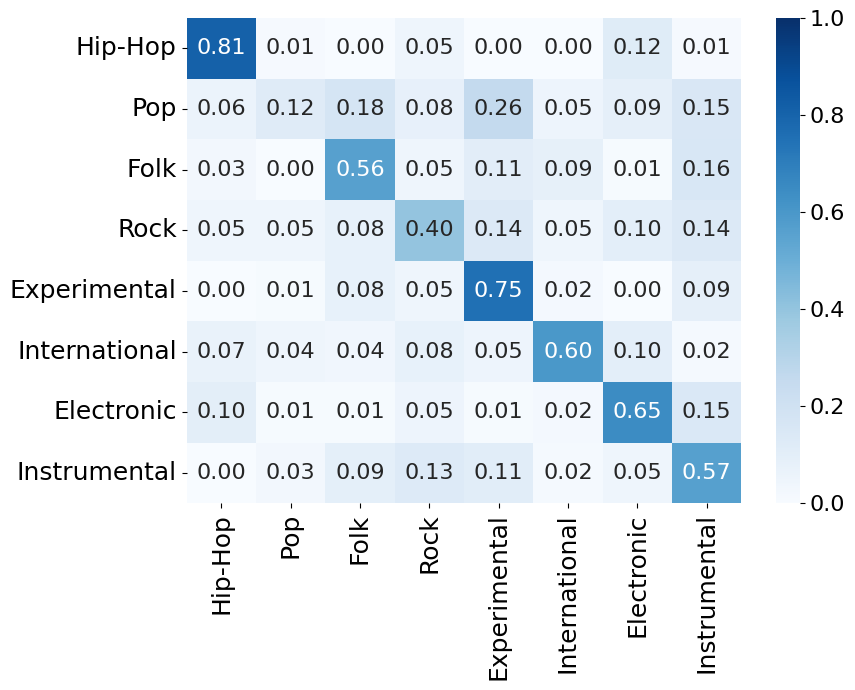

In [ ]:
plot_CM(class_names, "confusion_matrix_Fusion_resume_2.csv")

## Final plots

In [ ]:
name_list = [["results_Baseline_A_2D.csv", "results_Baseline_A_2D_resume_1.csv", "results_Baseline_A_2D_resume_2.csv"],
             ["results_Baseline_B_2D.csv", "results_Baseline_B_2D_resume_1.csv", "results_Baseline_B_2D_resume_2.csv"],
             ["results_Densenet.csv", "results_Densenet_resume_1.csv", "results_Densenet_resume_2.csv"],
             ["results_Fusion.csv", "results_Fusion_resume_1.csv", "results_Fusion_resume_2.csv"]]

In [ ]:
checkpoint_list = [["checkpoint_Baseline_A_2D.pt", "checkpoint_Baseline_A_2D_resume_1.pt", "checkpoint_Baseline_A_2D_resume_2.pt"],
                   ["checkpoint_Baseline_B_2D.pt", "checkpoint_Baseline_B_2D_resume_1.pt", 'checkpoint_Baseline_B_2D_resume_2.pt'],
                   ["checkpoint_Densenet.pt", "checkpoint_Densenet_resume_1.pt", 'checkpoint_Densenet_resume_2.pt'],
                   ["checkpoint_Fusion.pt", "checkpoint_Fusion_resume_1.pt", 'checkpoint_Fusion_resume_2.pt']]

In [ ]:
color = ['blue', 'gold', 'red', 'green']
labels = ['Baseline A', 'Baseline B', 'Densenet', 'Fusionet']

In [ ]:
def final_plot(name_list, checkpoint_list, train = True, metric = 'loss'):



    fig, ax = plt.subplots(figsize = (21, 14))

    for l in range(len(name_list)):
        results_name = name_list[l]
        checkpoint_name = checkpoint_list[l]

        train_frames = []
        valid_frames = []

        for i in range(len(checkpoint_name)):
            best_epoch = torch.load(os.path.join(DATA_DIR + '/checkpoints', checkpoint_name[i]), map_location=device)["epoch"]
            train_frames.append(pd.read_csv(DATA_DIR + "/results/train_" + results_name[i]).iloc[:best_epoch])
            valid_frames.append(pd.read_csv(DATA_DIR + "/results/valid_" + results_name[i]).iloc[:best_epoch])

        train_results_df = pd.concat(train_frames, ignore_index = True)
        valid_results_df = pd.concat(valid_frames, ignore_index = True)

        assert len(train_results_df) == len(valid_results_df)
        n_epochs = len(train_results_df)


        if train:
            ax.plot(np.arange(n_epochs) + 1, train_results_df[metric], linewidth = 3, color = color[l], label = labels[l])
            ax.set_title('Train set: '+metric, fontsize= 20)
        else:
            ax.plot(np.arange(n_epochs) + 1, valid_results_df[metric], linewidth = 3,color = color[l], label = labels[l])
            ax.set_title('Valid set: '+metric, fontsize= 20)

        ax.set_xlabel("epoch", fontsize = 18)
        ax.set_ylabel(metric, fontsize = 18)
        ax.tick_params(axis='both', labelsize=16)
        ax.legend(fontsize = 16)
        ax.grid(ls='--')


    plt.show()

In [ ]:
def final_plot_same(name_list, checkpoint_list, metric = 'loss'):



    fig, ax = plt.subplots(figsize = (21, 14))

    for l in range(len(name_list)):
        results_name = name_list[l]
        checkpoint_name = checkpoint_list[l]

        train_frames = []
        valid_frames = []

        for i in range(len(checkpoint_name)):
            best_epoch = torch.load(os.path.join(DATA_DIR + '/checkpoints', checkpoint_name[i]), map_location=device)["epoch"]
            train_frames.append(pd.read_csv(DATA_DIR + "/results/train_" + results_name[i]).iloc[:best_epoch])
            valid_frames.append(pd.read_csv(DATA_DIR + "/results/valid_" + results_name[i]).iloc[:best_epoch])

        train_results_df = pd.concat(train_frames, ignore_index = True)
        valid_results_df = pd.concat(valid_frames, ignore_index = True)

        assert len(train_results_df) == len(valid_results_df)
        n_epochs = len(train_results_df)


        ax.plot(np.arange(n_epochs) + 1, train_results_df[metric], linewidth = 3, color = color[l], label = labels[l])
        ax.plot(np.arange(n_epochs) + 1, valid_results_df[metric], linewidth = 3,color = color[l], alpha=0.5, ls='--')

        ax.set_xlabel("epoch", fontsize = 18)
        ax.set_ylabel(metric, fontsize = 18)
        ax.tick_params(axis='both', labelsize=16)
        ax.legend(fontsize = 16)
        ax.grid(ls='--')



    plt.show()

In [ ]:
final_plot_same(name_list, checkpoint_list)

In [ ]:
final_plot_same(name_list, checkpoint_list, 'MA_F1_score')

In [ ]:
final_plot(name_list, checkpoint_list)

In [ ]:
final_plot(name_list, checkpoint_list, train= False, metric='loss')

In [ ]:
final_plot(name_list, checkpoint_list, train= True, metric='MA_F1_score')

In [ ]:
final_plot(name_list, checkpoint_list, train= False, metric='MA_F1_score')